# [AIG100 – Project 3: Income Classification using Neural Networks](hhttp://github.com/jcp-tech/Seneca_Class_Notes/blob/master/Semester%201/AIG100%20-%20Machine%20Learing/Project%203/Project%203%20-%20AIG100%20-%20Jonathan%20Chacko.ipynb)

<!--
## Table of Contents

1. [Introduction](#Introduction)
2. [Dataset Overview & Significance](#Dataset-Overview--Significance)
3. [Data Cleaning & Preprocessing](#Data-Cleaning--Preprocessing)
   - [Loading the Dataset](#Loading-the-Dataset)
   - [Data Cleaning Steps](#Data-Cleaning-Steps)
4. [Exploratory Data Analysis](#Exploratory-Data-Analysis)
   - [Analysis of Numerical Features](#Analysis-of-Numerical-Features)
   - [Analysis of Categorical Features](#Analysis-of-Categorical-Features)
5. [Data Preprocessing & Feature Engineering](#Data-Preprocessing--Feature-Engineering)
   - [Train-Test Split and Class Distribution](#Train-Test-Split-and-Class-Distribution)
   - [Handling Class Imbalance](#Handling-Class-Imbalance)
6. [Modeling Approach](#Modeling-Approach)
7. [Evaluation & Results](#Evaluation--Results)
   - [Cross-Validation Performance](#Cross-Validation-Performance)
   - [Model Architecture Summary](#Model-Architecture-Summary)
   - [Learning Curves](#Learning-Curves)
   - [Final Test Set Evaluation](#Final-Test-Set-Evaluation)
   - [Confusion Matrix Visualization](#Confusion-Matrix-Visualization)
   - [Per-Class Performance Metrics](#Per-Class-Performance-Metrics)
   - [ROC Curve Analysis](#ROC-Curve-Analysis)
   - [Precision-Recall Curve](#Precision-Recall-Curve)
8. [Model Interpretation & Insights](#Model-Interpretation--Insights)
   - [Key Findings](#Key-Findings)
   - [Model Performance Analysis](#Model-Performance-Analysis)
   - [Feature Importance Observations](#Feature-Importance-Observations)
9. [Real-World Applications & Implications](#Real-World-Applications--Implications)
   - [Use Cases in Financial Services](#Use-Cases-in-Financial-Services)
   - [Ethical Considerations](#Ethical-Considerations)
   - [Limitations & Potential Improvements](#Limitations--Potential-Improvements)
10. [Reflection](#Reflection)
11. [Conclusion](#Conclusion)
12. [References](#References)
-->

## Introduction

### Project Title
**Predicting Loan Default Risk Using Census Income Data**

### Objective
To build a neural network model that classifies individuals as low-risk or high-risk loan applicants, based on demographic and socio-economic data from the UCI Census Income dataset.

### Background
Financial institutions face the constant challenge of determining whether a loan applicant is likely to default. Traditionally, this involves credit history and financial statements—but what if we could leverage broader demographic and employment features to predict credit risk?

By classifying whether a person earns more than $50K per year using neural networks, we indirectly estimate their income capacity, a crucial factor in loan repayment ability. High-income individuals are typically lower-risk, while lower-income applicants may pose greater risk, especially without collateral or prior credit history.

<!-- 
### Note
I decided to Approach this Project with a more practical Perspective to see if i can solve a Problem with the Data in Hand. 
-->

## Dataset Overview & Significance

### Dataset Details
- **Source**: [UCI Census Income Dataset](https://archive.ics.uci.edu/dataset/20/census+income)
- **Structure**: ~48,842 rows, 14 feature columns plus target variable
- **Target Variable**: `income` (binary: >$50K or ≤$50K)
<!-- - **Class Distribution**: Approximately 75% ≤$50K, 25% >$50K (imbalanced) -->

### Why This Project Matters

This project addresses a critical business need in the financial sector: accurately assessing loan default risk. Traditional methods rely heavily on credit history, which disadvantages those with limited credit records (the "thin file" problem). By leveraging demographic and socioeconomic data, we can create more inclusive risk assessment models.


## Data Cleaning & Preprocessing

In [1]:
# === General Libraries ===
import warnings, os, math, shutil, json
# from IPython.display import Markdown, display
from ucimlrepo import fetch_ucirepo 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# === Data Preprocessing ===
from sklearn.preprocessing import StandardScaler, OneHotEncoder # , OrdinalEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import KFold
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# === Evaluation Metrics ===
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, # f1_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    # mean_squared_error, r2_score, mean_absolute_error,
    precision_recall_curve, average_precision_score,
    roc_curve, roc_auc_score # , auc
)

# === TensorFlow / Keras ===
import tensorflow as tf
# from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import (
    Dense, Dropout, BatchNormalization,
    # Input, Flatten, Embedding, Concatenate, Reshape,
    LeakyReLU
)
# from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam

# Ignore warnings for cleaner output
warnings.filterwarnings('ignore')

### Loading the Dataset

In [121]:
# fetch dataset
census_income = fetch_ucirepo(id=20) # https://archive.ics.uci.edu/dataset/20/census+income
# print(census_income.metadata) # metadata 
# print(census_income.variables) # variable information 
df = pd.concat([census_income.data.features, census_income.data.targets], axis=1)
df

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,39,Private,215419,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States,<=50K.
48838,64,NaN,321403,HS-grad,9,Widowed,NaN,Other-relative,Black,Male,0,0,40,United-States,<=50K.
48839,38,Private,374983,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,<=50K.
48840,44,Private,83891,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States,<=50K.


In [122]:
df.shape

(48842, 15)

In [123]:
df.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income'],
      dtype='object')

In [124]:
df.isnull().sum() # check for null values

age                 0
workclass         963
fnlwgt              0
education           0
education-num       0
marital-status      0
occupation        966
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
native-country    274
income              0
dtype: int64

In [125]:
# Showing the Values in Each Column
for col in df.columns:
    print(f"Column: `{col}`")
    print(df[col].unique())
    print("\n")

Column: `age`
[39 50 38 53 28 37 49 52 31 42 30 23 32 40 34 25 43 54 35 59 56 19 20 45
 22 48 21 24 57 44 41 29 18 47 46 36 79 27 67 33 76 17 55 61 70 64 71 68
 66 51 58 26 60 90 75 65 77 62 63 80 72 74 69 73 81 78 88 82 83 84 85 86
 87 89]


Column: `workclass`
['State-gov' 'Self-emp-not-inc' 'Private' 'Federal-gov' 'Local-gov' '?'
 'Self-emp-inc' 'Without-pay' 'Never-worked' nan]


Column: `fnlwgt`
[ 77516  83311 215646 ... 173449  89686 350977]


Column: `education`
['Bachelors' 'HS-grad' '11th' 'Masters' '9th' 'Some-college' 'Assoc-acdm'
 'Assoc-voc' '7th-8th' 'Doctorate' 'Prof-school' '5th-6th' '10th'
 '1st-4th' 'Preschool' '12th']


Column: `education-num`
[13  9  7 14  5 10 12 11  4 16 15  3  6  2  1  8]


Column: `marital-status`
['Never-married' 'Married-civ-spouse' 'Divorced' 'Married-spouse-absent'
 'Separated' 'Married-AF-spouse' 'Widowed']


Column: `occupation`
['Adm-clerical' 'Exec-managerial' 'Handlers-cleaners' 'Prof-specialty'
 'Other-service' 'Sales' 'Craft-repair' '

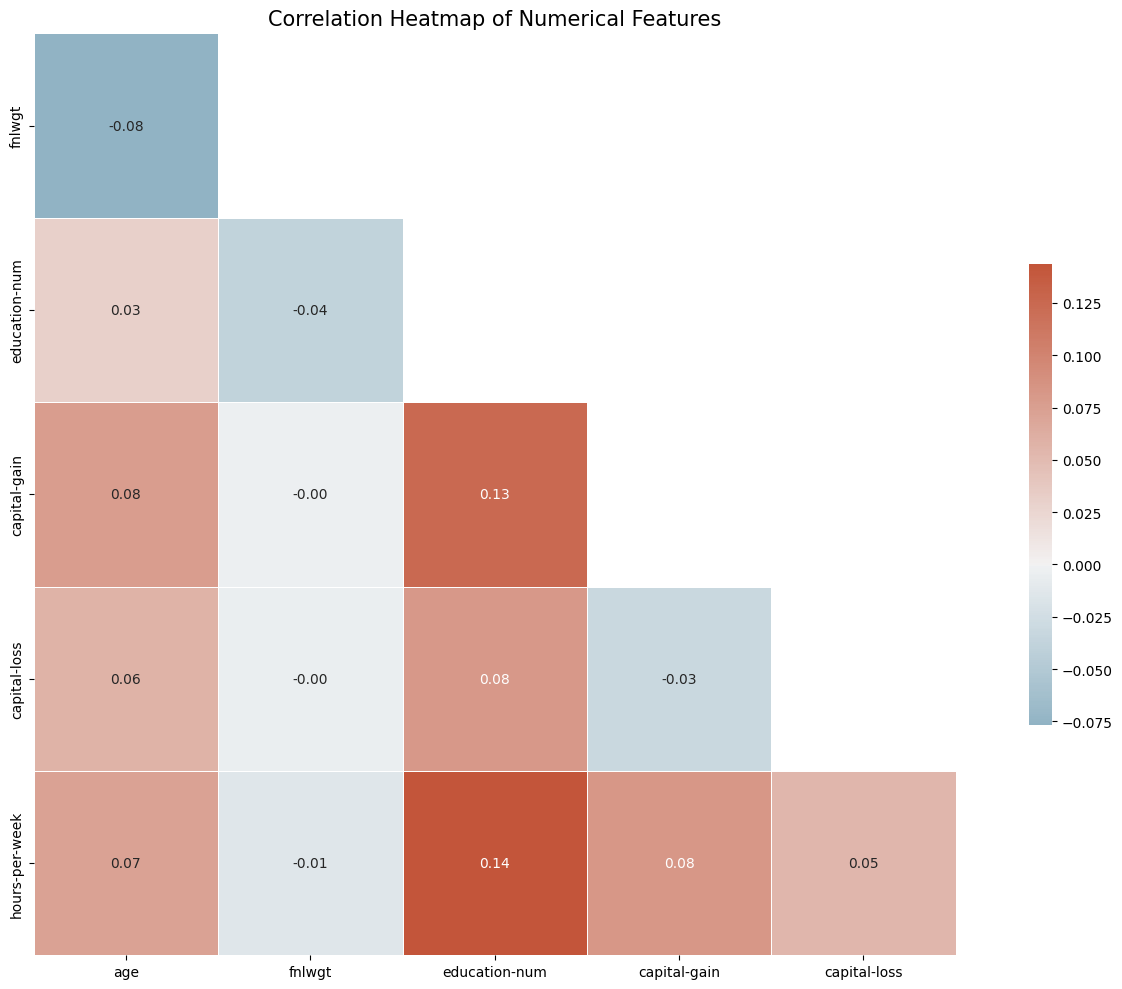

In [126]:
numeric_df = df.select_dtypes(include=['int64', 'float64']) # Create a copy of the dataframe with only numeric columns
corr_matrix = numeric_df.corr() # Compute correlation matrix
mask = np.triu(np.ones_like(corr_matrix, dtype=bool)) # Apply mask
corr_matrix_trimmed = corr_matrix.iloc[1:, :-1]
mask_trimmed = mask[1:, :-1]
plt.figure(figsize=(15, 10))# Plot heatmap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(
    corr_matrix_trimmed,
    mask=mask_trimmed,
    annot=True,
    fmt='.2f',
    cmap=cmap,
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={'shrink': 0.5}
)
plt.title('Correlation Heatmap of Numerical Features', fontsize=15)
plt.tight_layout()
plt.show()

In [127]:
df.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


### Data Cleaning Steps

In [128]:
# 1. Handling missing values (replacing `'?'` with `NaN` and dropping rows)
df[df=='?']=np.nan # Replacing '?' with NaN
df=df.dropna(axis=0) # Dropping all rows with NaN values
# df = df[~(df['native-country'] == "?") | (df['native-country'].isnull())] # ALTERNATIVE Removing all rows with Unknown Countries as part of data cleaning process

In [129]:
# 2. Transforming categorical variables (age binning)
df['age'] = pd.cut(df['age'], bins=[0, 30, 60, 100], labels=['Young', 'Middle-aged', 'Old']) # .astype('category')

In [130]:
# 3. Feature engineering (creating capital-profit from gain/loss)
df['capital-metrics'] = df['capital-gain'] - df['capital-loss']
df['capital-profit'] = df['capital-metrics'].apply(lambda x: 0 if x < 0 else 1)
df.drop(columns=['capital-gain', 'capital-loss', 'capital-metrics'], inplace=True)

In [131]:
df.info() # check the data types and null values

<class 'pandas.core.frame.DataFrame'>
Index: 45222 entries, 0 to 48841
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             45222 non-null  category
 1   workclass       45222 non-null  object  
 2   fnlwgt          45222 non-null  int64   
 3   education       45222 non-null  object  
 4   education-num   45222 non-null  int64   
 5   marital-status  45222 non-null  object  
 6   occupation      45222 non-null  object  
 7   relationship    45222 non-null  object  
 8   race            45222 non-null  object  
 9   sex             45222 non-null  object  
 10  hours-per-week  45222 non-null  int64   
 11  native-country  45222 non-null  object  
 12  income          45222 non-null  object  
 13  capital-profit  45222 non-null  int64   
dtypes: category(1), int64(4), object(9)
memory usage: 4.9+ MB


In [132]:
# 4. Removing irrelevant features
df.drop(columns=['fnlwgt', 'education'], inplace=True) # Dropping the fnlwgt and education columns as they are not relevant to the analysis
df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

In [133]:
# 5. Standardizing the target variable
df['income'] = df['income'].str.replace('.', '')
df['income'].replace({'<=50K': 0, '>50K': 1}, inplace=True)
# df['income'] = df['income'].astype('category')
df['income'].value_counts()

income
0    34014
1    11208
Name: count, dtype: int64

## Exploratory Data Analysis

In [134]:
# Separate features
numerical_features_temp = df.select_dtypes(include=['int64', 'float64']).drop(columns=['income', 'capital-profit']).columns.tolist()
categorical_features_temp = df.select_dtypes(include=['object', 'category']).columns.tolist()

### Analysis of Numerical Features

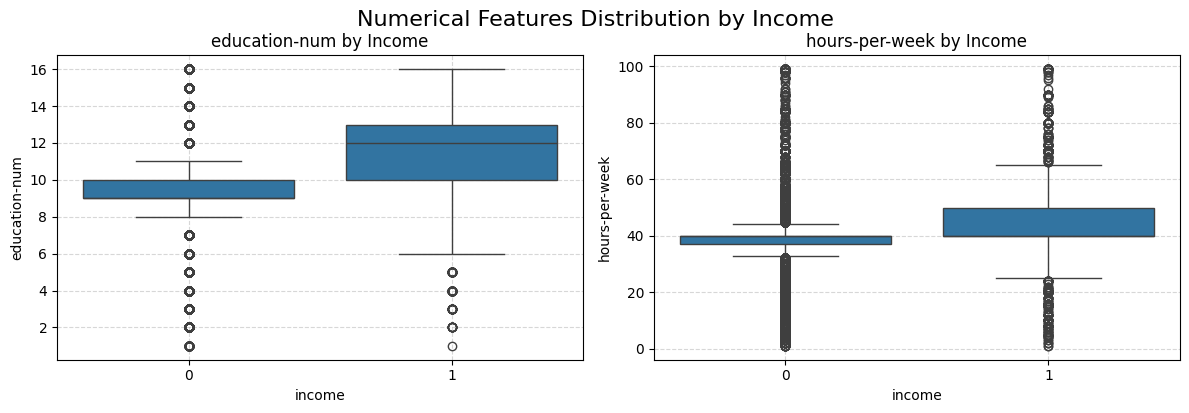

In [135]:
# === NUMERICAL FEATURES ===
num_cols = 2
num_rows = math.ceil(len(numerical_features_temp) / num_cols)
plt.figure(figsize=(num_cols * 6, num_rows * 4))

for i, feature in enumerate(numerical_features_temp):
    plt.subplot(num_rows, num_cols, i + 1)
    sns.boxplot(data=df, x='income', y=feature)
    plt.title(f"{feature} by Income")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()

plt.suptitle("Numerical Features Distribution by Income", y=1.02, fontsize=16)
plt.show()

### Analysis of Categorical Features

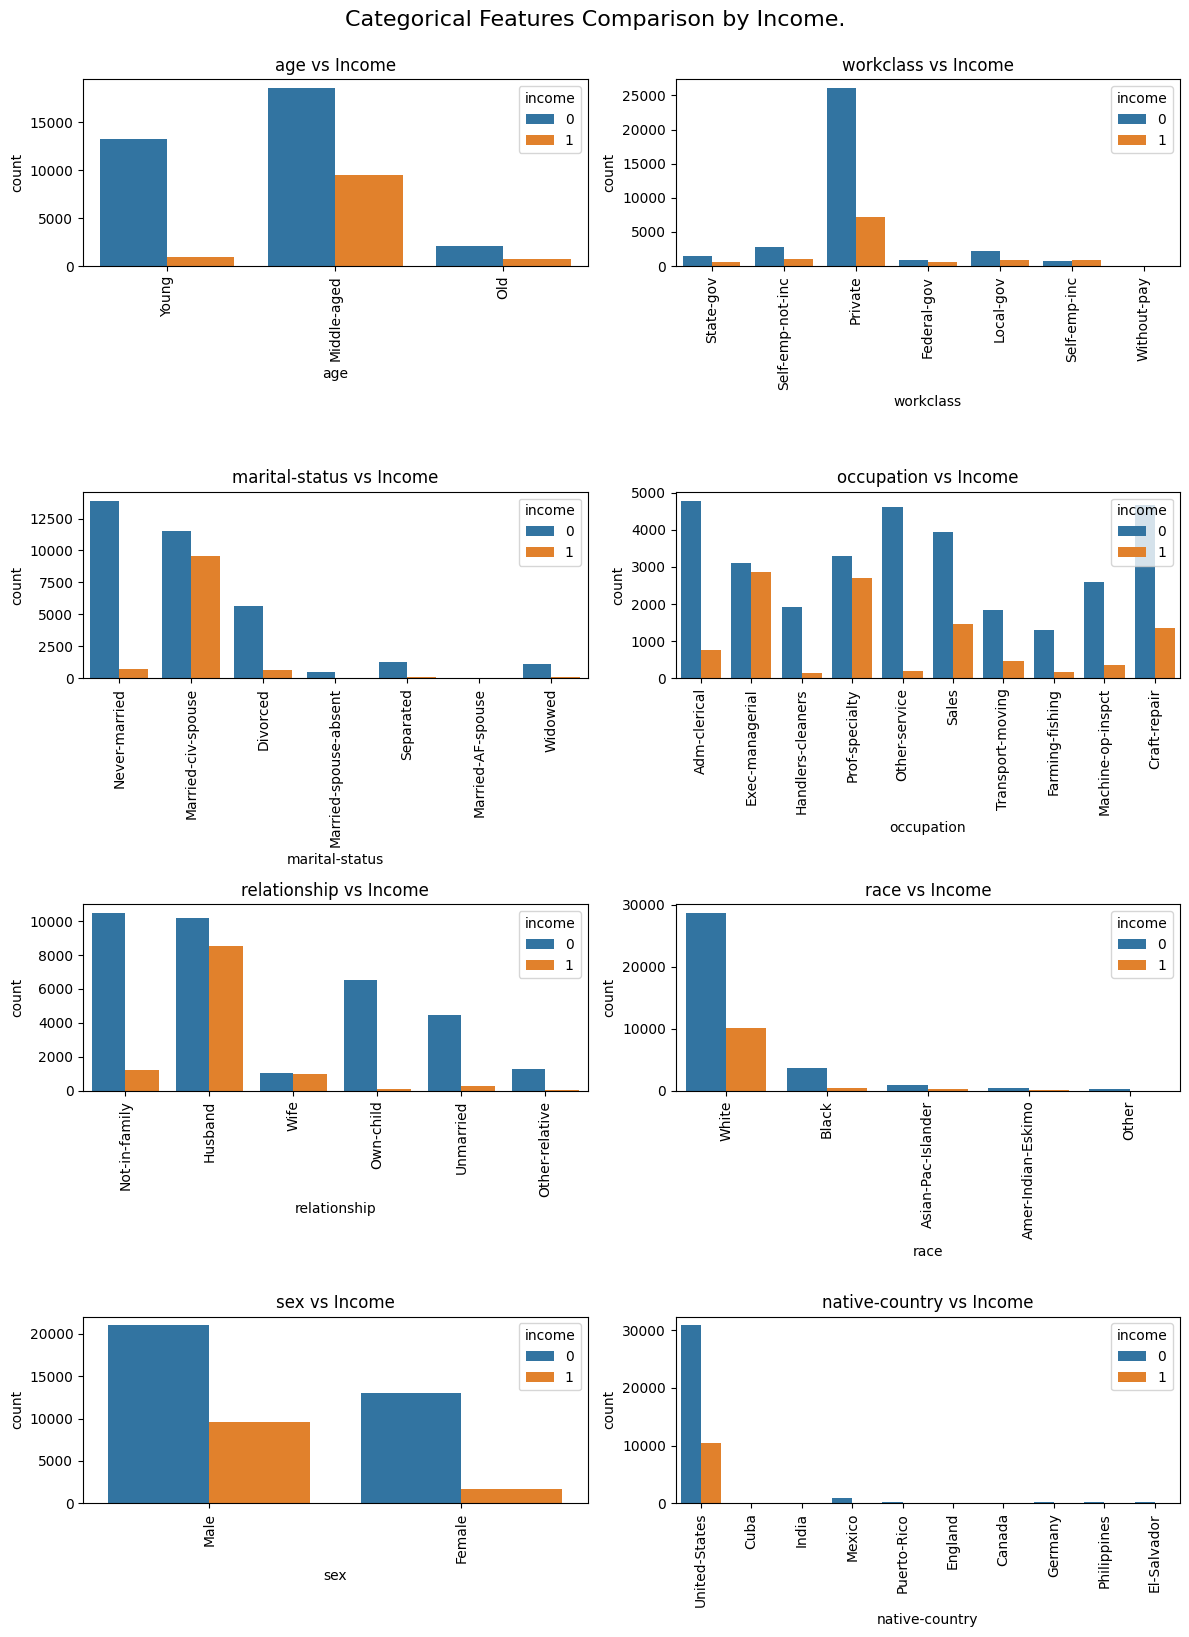

In [136]:
# === CATEGORICAL FEATURES ===
cat_cols = 2
cat_rows = math.ceil(len(categorical_features_temp) / cat_cols)
plt.figure(figsize=(cat_cols * 6, cat_rows * 4))

for i, feature in enumerate(categorical_features_temp):
    plt.subplot(cat_rows, cat_cols, i + 1)

    # Get top 10 most common categories (if needed)
    top_categories = df[feature].value_counts().nlargest(10).index
    filtered_df = df[df[feature].isin(top_categories)]

    sns.countplot(data=filtered_df, x=feature, hue='income')
    plt.title(f"{feature} vs Income")
    plt.xticks(rotation=90)
    plt.tight_layout()

plt.suptitle("Categorical Features Comparison by Income.", y=1.02, fontsize=16)
plt.show()

## Data Preprocessing & Feature Engineering

In [ ]:
target = 'income' # Setting the target variable

# Create preprocessing pipelines for numerical and categorical data
numeric_features = [f for f in df.select_dtypes(include=[np.number, 'number', 'float64', 'int64', 'float32', 'int32']).columns.to_list() if f != target]
categorical_features = [f for f in df.select_dtypes(include=["object", "category"]).columns.to_list() if f != target ]

# Numeric pipeline with standard scaling
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
# Categorical pipeline with one-hot encoding
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(
        # drop='first',
        # sparse_output=False, # Return dense array
        handle_unknown="ignore"
    )),
    # ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

### Train-Test Split and Class Distribution

In [138]:
# Create X and y
X = df.drop(columns=[target])
y = df[target]

In [139]:
# First split: separate out the test set (80% train+val, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

# Verify the split proportions
print(f"Test set size: {X_test.shape[0]} ({X_test.shape[0]/X.shape[0]:.2%} of total)")

Test set size: 9045 (20.00% of total)


In [140]:
# Check class distribution in each set
print(f"\nClass distribution:")
print(f"Overall: {y.value_counts(normalize=True).to_dict()}")
print(f"Test: {y_test.value_counts(normalize=True).to_dict()}")


Class distribution:
Overall: {0: 0.7521560302507629, 1: 0.2478439697492371}
Test: {0: 0.7521282476506357, 1: 0.2478717523493643}


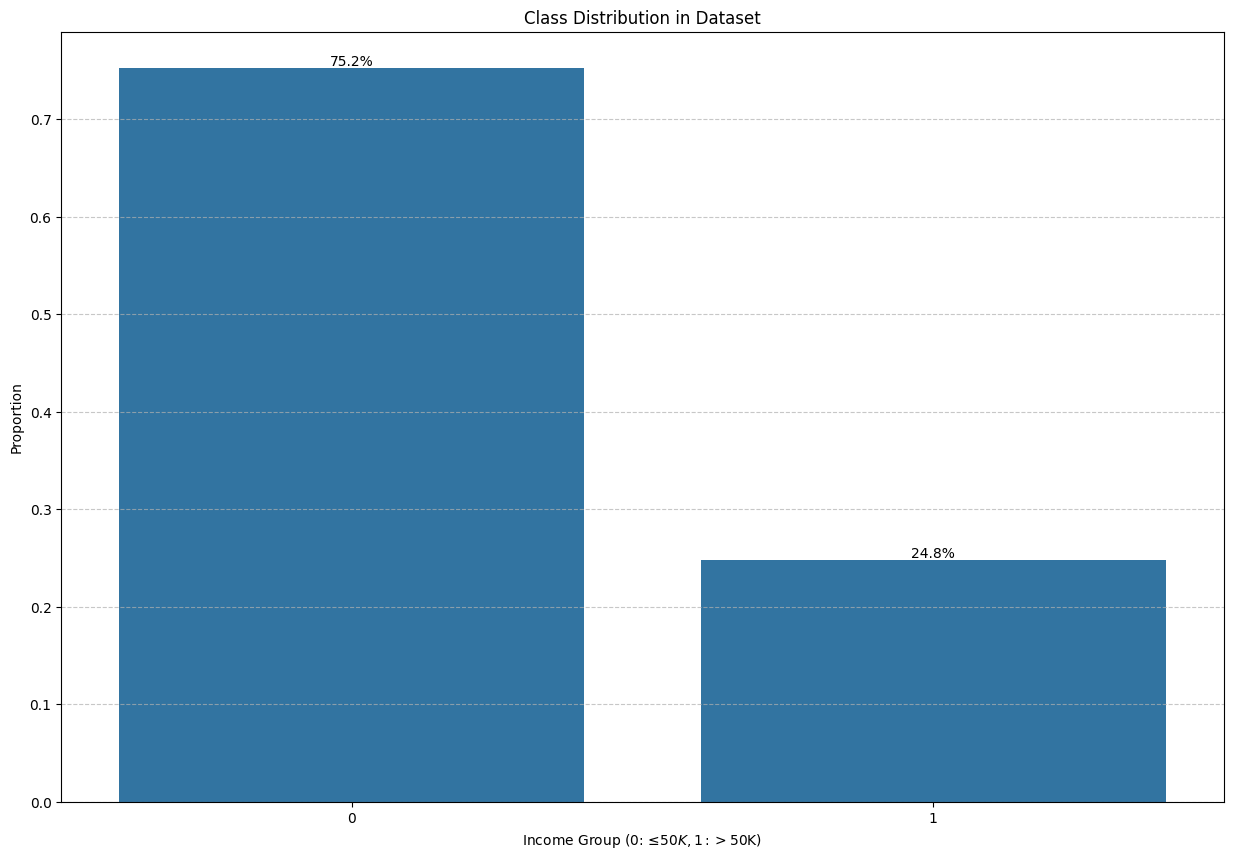

Class distribution in dataset:


income
0    0.752156
1    0.247844
Name: proportion, dtype: float64

In [141]:
# Check class distribution in the dataset
class_distribution = y.value_counts(normalize=True)
plt.figure(figsize=(15, 10)) # Create a bar plot of the class distribution
ax = sns.barplot(x=class_distribution.index, y=class_distribution.values)
plt.title('Class Distribution in Dataset')
plt.xlabel('Income Group (0: ≤$50K, 1: >$50K)')
plt.ylabel('Proportion')
for i, p in enumerate(ax.patches): # Add percentage labels on top of the bars
    height = p.get_height()
    ax.annotate(f'{height:.1%}', (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
print(r"Class distribution in dataset:")
class_distribution

In [142]:
# Dynamic Interpretation
def interpret_dataset_class_distribution(class_distribution):
    interpretation = []
    interpretation.append("Class Distribution in Full Dataset")
    # Ensure it's a dictionary
    if hasattr(class_distribution, 'to_dict'):
        class_distribution = class_distribution.to_dict()
    for cls, proportion in class_distribution.items():
        interpretation.append(f"- Class {cls}: {proportion:.1%} of total samples")
    majority_class = max(class_distribution, key=class_distribution.get)
    minority_class = min(class_distribution, key=class_distribution.get)
    majority_ratio = class_distribution[majority_class]
    minority_ratio = class_distribution[minority_class]
    imbalance_ratio = majority_ratio / minority_ratio
    interpretation.append(f"\n- Imbalance ratio (majority:minority) => {imbalance_ratio:.2f}:1")
    if imbalance_ratio > 1.5:
        interpretation.append("\nThere is a significant class imbalance in the dataset.")
        interpretation.append("Without corrective measures, the model may favor the majority class.")
        interpretation.append("To address this, techniques like class weighting, resampling, or threshold tuning are recommended.")
    else:
        interpretation.append("\nThe dataset is relatively balanced, so class imbalance should not heavily impact performance.")
    return "\n".join(interpretation)
print(interpret_dataset_class_distribution(class_distribution))

Class Distribution in Full Dataset
- Class 0: 75.2% of total samples
- Class 1: 24.8% of total samples

- Imbalance ratio (majority:minority) => 3.03:1

There is a significant class imbalance in the dataset.
Without corrective measures, the model may favor the majority class.
To address this, techniques like class weighting, resampling, or threshold tuning are recommended.


### Handling Class Imbalance

In [143]:
# Since our dataset has an imbalance we'll calculate class weights to ensure the model pays sufficient attention to the minority class during training.
y_train_series = pd.Series(y_train)
class_counts = y_train_series.value_counts().sort_index()
classes = np.array(class_counts.index)  # instead of .to_list()
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_series)
class_weight_dict = dict(zip(classes, weights))
# class_weight_dict = {i: weight for i, weight in enumerate(len(y_train) / (len(np.unique(y_train)) * np.bincount(y_train)))}
print(r"Class weights for model training:")
print(json.dumps({int(key):float(value) for key, value in class_weight_dict.items()}, indent=4))

Class weights for model training:
{
    "0": 0.6647495498144133,
    "1": 2.0174548293553425
}


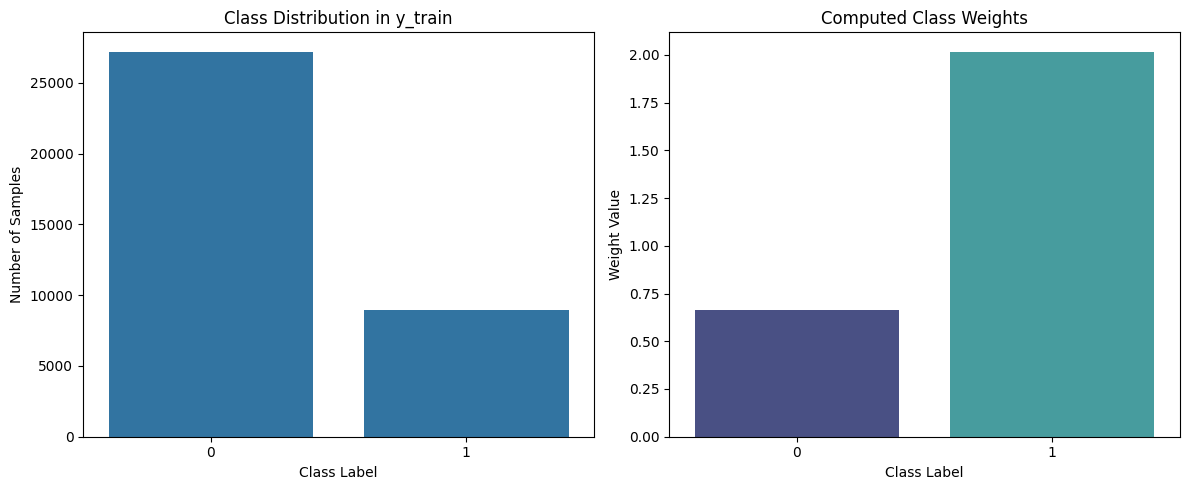

In [144]:
# Plotting
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
# Plot 1: Class Distribution
sns.barplot(x=class_counts.index, y=class_counts.values, ax=ax[0])
ax[0].set_title('Class Distribution in y_train')
ax[0].set_xlabel('Class Label')
ax[0].set_ylabel('Number of Samples')
# Plot 2: Computed Class Weights
sns.barplot(x=list(class_weight_dict.keys()), y=list(class_weight_dict.values()), ax=ax[1], palette="mako")
ax[1].set_title('Computed Class Weights')
ax[1].set_xlabel('Class Label')
ax[1].set_ylabel('Weight Value')
plt.tight_layout()
plt.show()

In [145]:
# Dynamic Interpretation
def interpret_class_weights(class_counts, class_weight_dict):
    interpretation = []
    interpretation.append("Class Distribution and Computed Weights Interpretation")
    # Convert to dictionary if it's a pandas Series
    if hasattr(class_counts, 'to_dict'):
        class_counts = class_counts.to_dict()
    total_samples = sum(class_counts.values())
    majority_class = max(class_counts, key=class_counts.get)
    minority_class = min(class_counts, key=class_counts.get)
    majority_count = class_counts[majority_class]
    minority_count = class_counts[minority_class]
    interpretation.append(f"- Total training samples: {total_samples}")
    interpretation.append(f"- Class {majority_class} has {majority_count} samples.")
    interpretation.append(f"- Class {minority_class} has {minority_count} samples.")
    imbalance_ratio = majority_count / minority_count
    interpretation.append(f"- Class imbalance ratio (majority/minority): {imbalance_ratio:.2f}")
    interpretation.append("\nComputed Class Weights:")
    for cls, weight in class_weight_dict.items():
        interpretation.append(f"- Class {cls}: Weight = {weight:.2f}")
    if imbalance_ratio > 1.5:
        interpretation.append("\nThe dataset is imbalanced. The Variable `class_weight_dict` is used to address this by giving more importance to the minority class during training.")
        interpretation.append("This encourages the model to pay equal attention to both classes by increasing the penalty for misclassifying underrepresented samples.")
        interpretation.append("As a result, class_weight helps the model avoid biasing predictions toward the majority class.")
    else:
        interpretation.append("\nThe class distribution is relatively balanced, so class weights may have limited effect.")
    return "\n".join(interpretation)
print(interpret_class_weights(class_counts, class_weight_dict))

Class Distribution and Computed Weights Interpretation
- Total training samples: 36177
- Class 0 has 27211 samples.
- Class 1 has 8966 samples.
- Class imbalance ratio (majority/minority): 3.03

Computed Class Weights:
- Class 0: Weight = 0.66
- Class 1: Weight = 2.02

The dataset is imbalanced. The Variable `class_weight_dict` is used to address this by giving more importance to the minority class during training.
This encourages the model to pay equal attention to both classes by increasing the penalty for misclassifying underrepresented samples.
As a result, class_weight helps the model avoid biasing predictions toward the majority class.


## Modeling Approach

In [146]:
# Initialize lists to store metrics and models
fold_metrics = []
fold_models = []

best_metric = -np.inf  # Initialize to very low number
best_fold_idx_number = -1
# best_model = None

folder_path = "ignore/fold_models" # os.makedirs("ignore/fold_models", exist_ok=True)

# If the folder exists, empty it
if os.path.exists(folder_path):
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)  # remove file or link
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)  # remove subdirectory
        except Exception as e:
            print(f'Failed to delete {file_path}. Reason: {e}')
else:
    os.makedirs(folder_path)  # create the folder if it doesn't exist


fold_historys = {}

# Configuration based on seeking high robustness and accuracy, ignoring time constraints:
number_of_folds = 10  # Use 10 folds for a robust cross-validation estimate of performance.
number_of_epochs = 300 # Set epochs high; this will be controlled by early stopping.

# KFold CV
kf = KFold(n_splits=number_of_folds, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
    print(f'\nFold {fold + 1}/{number_of_folds}')
    checkpoint_path = f'{folder_path}/fold_{fold + 1}.keras'

    # Train/Val Split
    X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # Preprocessing
    X_fold_train_processed = preprocessor.fit_transform(X_fold_train).astype('float32')
    X_fold_val_processed = preprocessor.transform(X_fold_val).astype('float32')
    # X_test_processed = preprocessor.transform(X_test).astype('float32')

    # Model
    input_dim = X_fold_train_processed.shape[1]
    keras_model = Sequential([
        # Input-level dropout to add noise and prevent overfitting from the start
        Dropout(0.1, input_shape=(input_dim,)),

        # First Dense layer with He initialization (good for ReLU/LeakyReLU)
        # Followed by LeakyReLU to avoid dead neuron problems
        Dense(256, kernel_initializer='he_normal'),
        LeakyReLU(alpha=0.1),  # Allows small gradients when input < 0
        BatchNormalization(),  # Normalize activations to improve convergence
        Dropout(0.3),          # Dropout to reduce overfitting

        # Second Dense layer with ReLU activation
        # BatchNorm and Dropout help regularize this layer
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        # Third Dense layer, similar structure
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),

        # Output layer for binary classification (sigmoid outputs probability)
        Dense(1, activation='sigmoid')
    ])

    keras_model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=0.001),
        metrics=['accuracy', tf.keras.metrics.Precision(name='precision'),
                 tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.AUC(name='auc')]
    )
    
    early_stopping = EarlyStopping(
        monitor='val_auc',
        patience=15,
        min_delta=0.001,  # minimum improvement threshold
        mode='max',
        restore_best_weights=True,
        verbose=1
    )

    model_checkpoint = ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_auc',  # track AUC for model selection
        mode='max',
        save_best_only=True,
        verbose=0
    )

    history = keras_model.fit(
        X_fold_train_processed, y_fold_train,
        validation_data=(X_fold_val_processed, y_fold_val),
        epochs=number_of_epochs,
        batch_size=64,
        class_weight=class_weight_dict,
        callbacks=[early_stopping, model_checkpoint], # Save the best model based on AUC
        verbose=0,
        shuffle=True # Shuffle the training data for each epoch
    )

    fold_historys[fold + 1] = history.history

    # Evaluation
    _, accuracy, precision, recall, auc = keras_model.evaluate(X_fold_val_processed, y_fold_val, verbose=0)
    
    # Store results
    fold_metrics.append({
        'fold': fold + 1,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'auc': auc
    })
    
    fold_models.append(keras_model)

    print(f'Fold {fold + 1} - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, AUC: {auc:.4f}')

    # Track best model by AUC
    if auc > best_metric:
        best_metric = auc
        # best_model = keras_model
        best_fold_idx_number = fold + 1


Fold 1/10
Epoch 31: early stopping
Restoring model weights from the end of the best epoch: 16.
Fold 1 - Accuracy: 0.7852, Precision: 0.5446, Recall: 0.8573, AUC: 0.8886

Fold 2/10
Epoch 27: early stopping
Restoring model weights from the end of the best epoch: 12.
Fold 2 - Accuracy: 0.7510, Precision: 0.4997, Recall: 0.8767, AUC: 0.8854

Fold 3/10
Epoch 19: early stopping
Restoring model weights from the end of the best epoch: 4.
Fold 3 - Accuracy: 0.7783, Precision: 0.5350, Recall: 0.8932, AUC: 0.8934

Fold 4/10
Epoch 26: early stopping
Restoring model weights from the end of the best epoch: 11.
Fold 4 - Accuracy: 0.7684, Precision: 0.5082, Recall: 0.8608, AUC: 0.8878

Fold 5/10
Epoch 17: early stopping
Restoring model weights from the end of the best epoch: 2.
Fold 5 - Accuracy: 0.7816, Precision: 0.5408, Recall: 0.8871, AUC: 0.8943

Fold 6/10
Epoch 26: early stopping
Restoring model weights from the end of the best epoch: 11.
Fold 6 - Accuracy: 0.7999, Precision: 0.5673, Recall: 0.

Fold 1 Training History


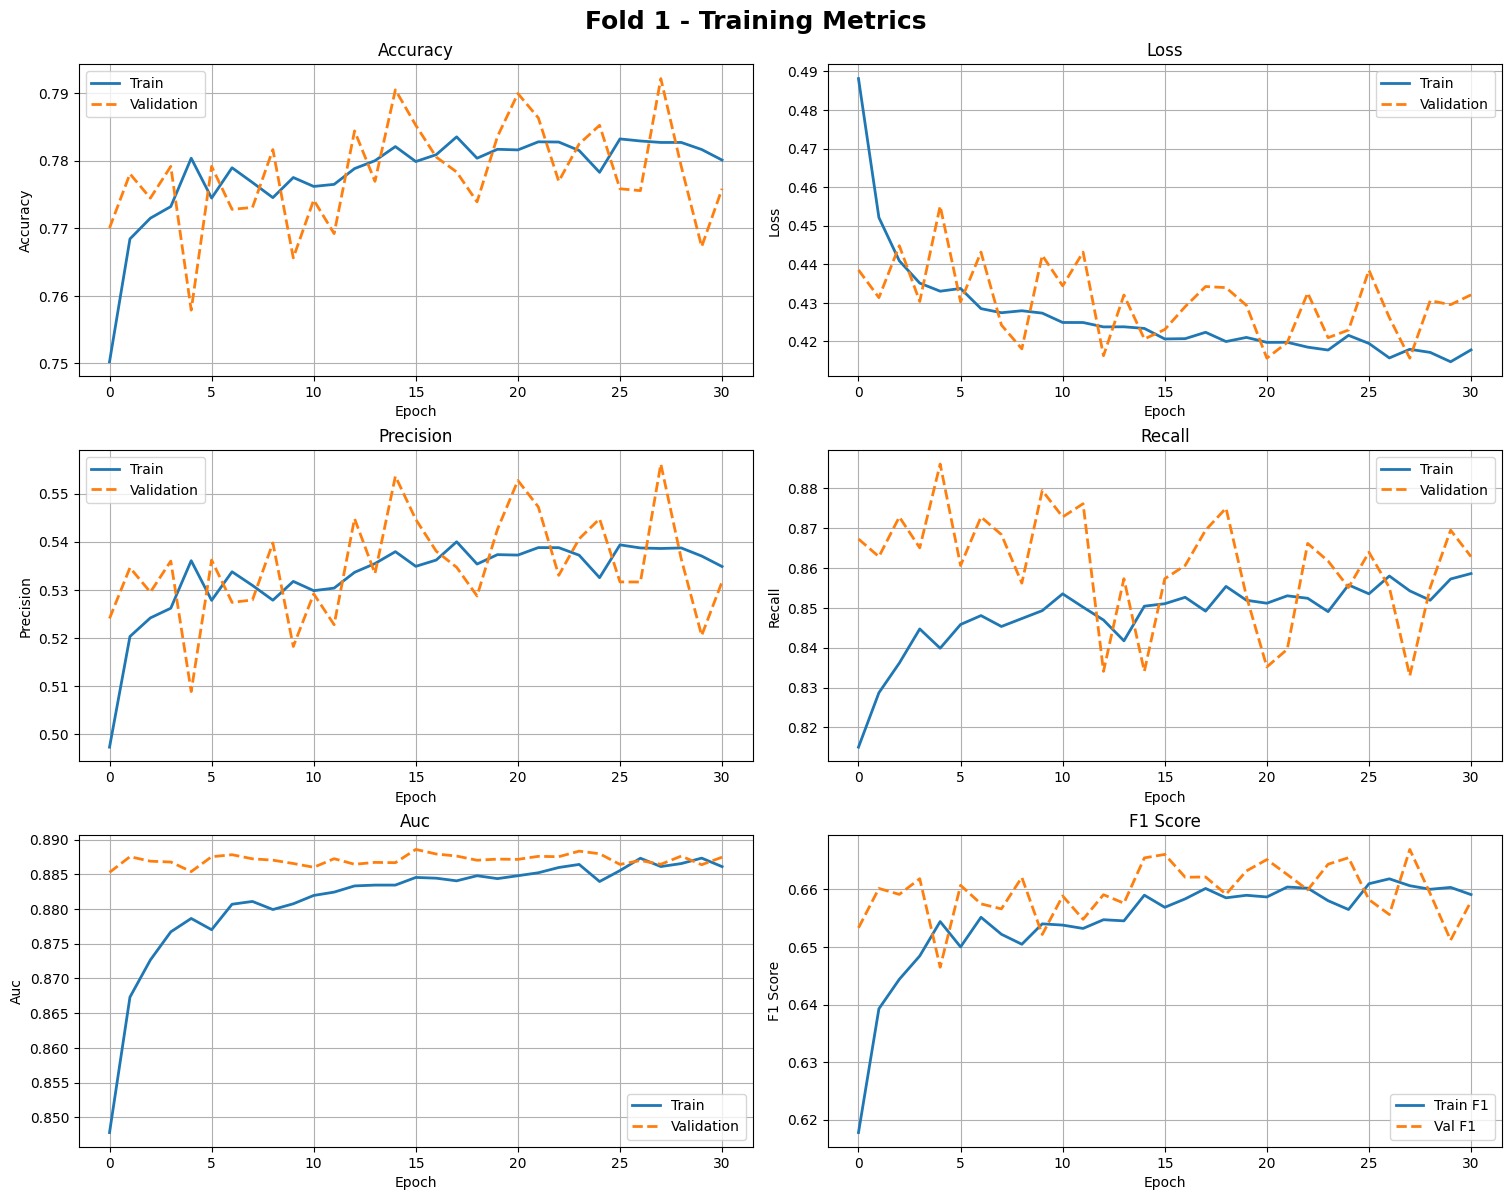

Fold 2 Training History


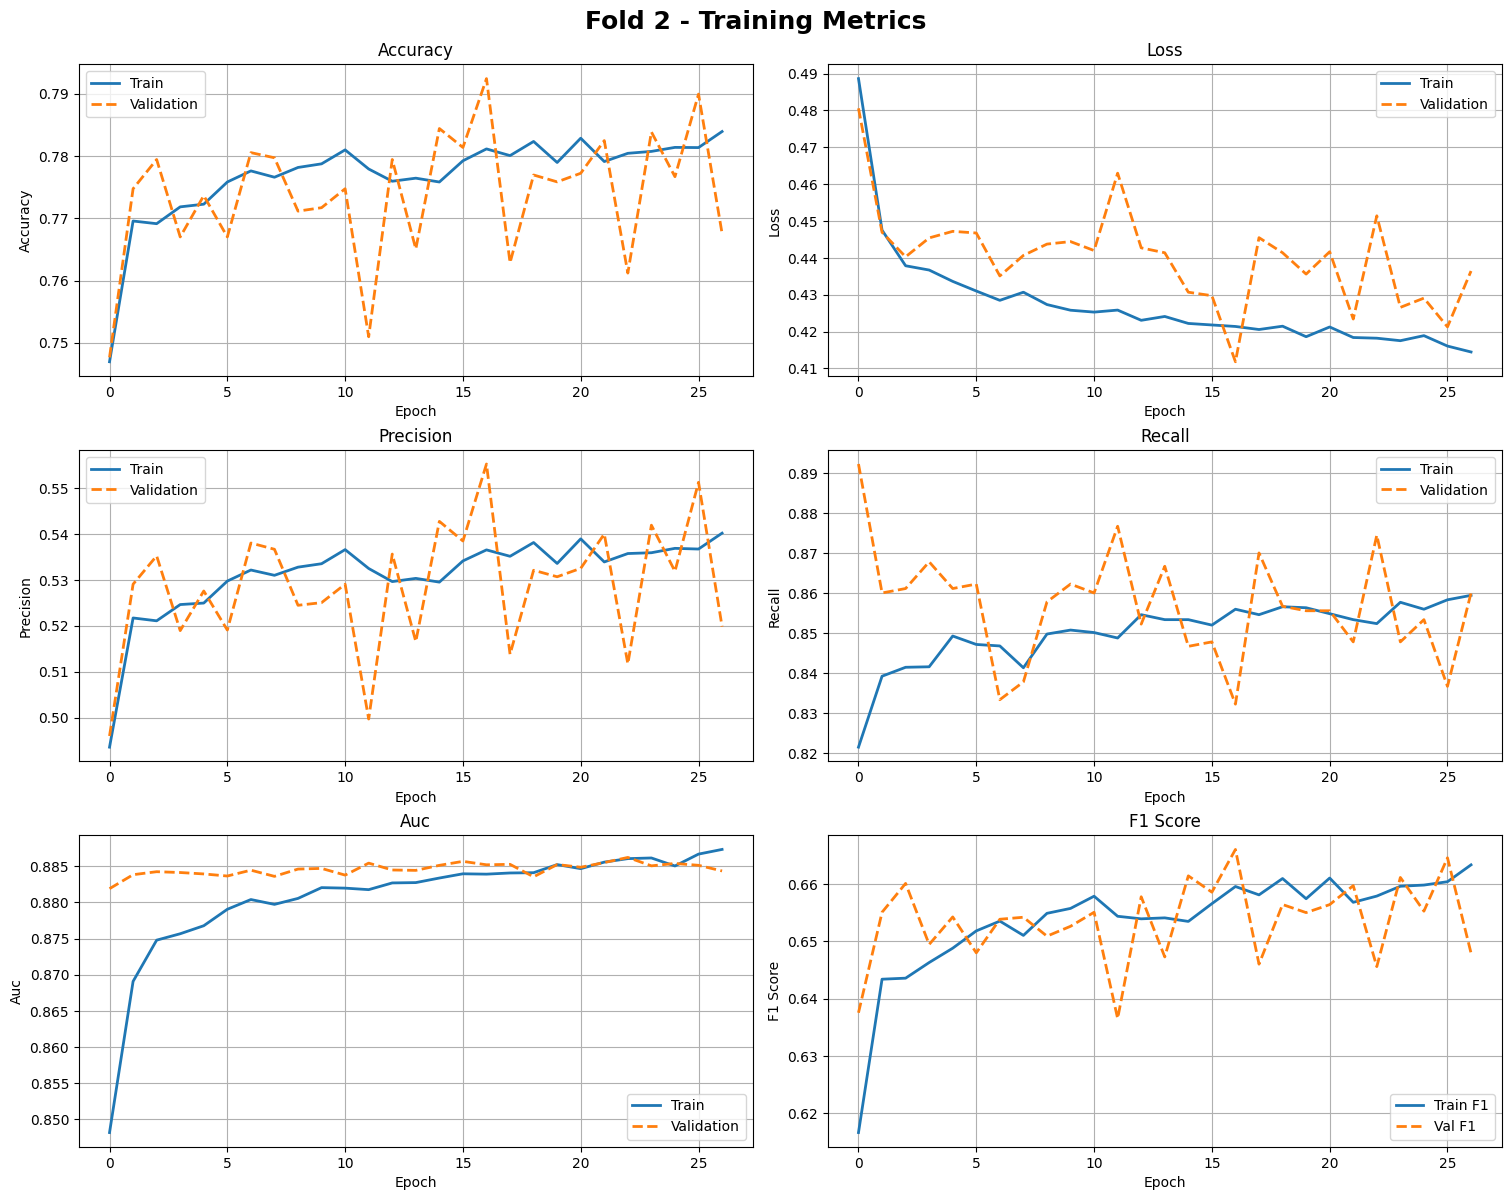

Fold 3 Training History


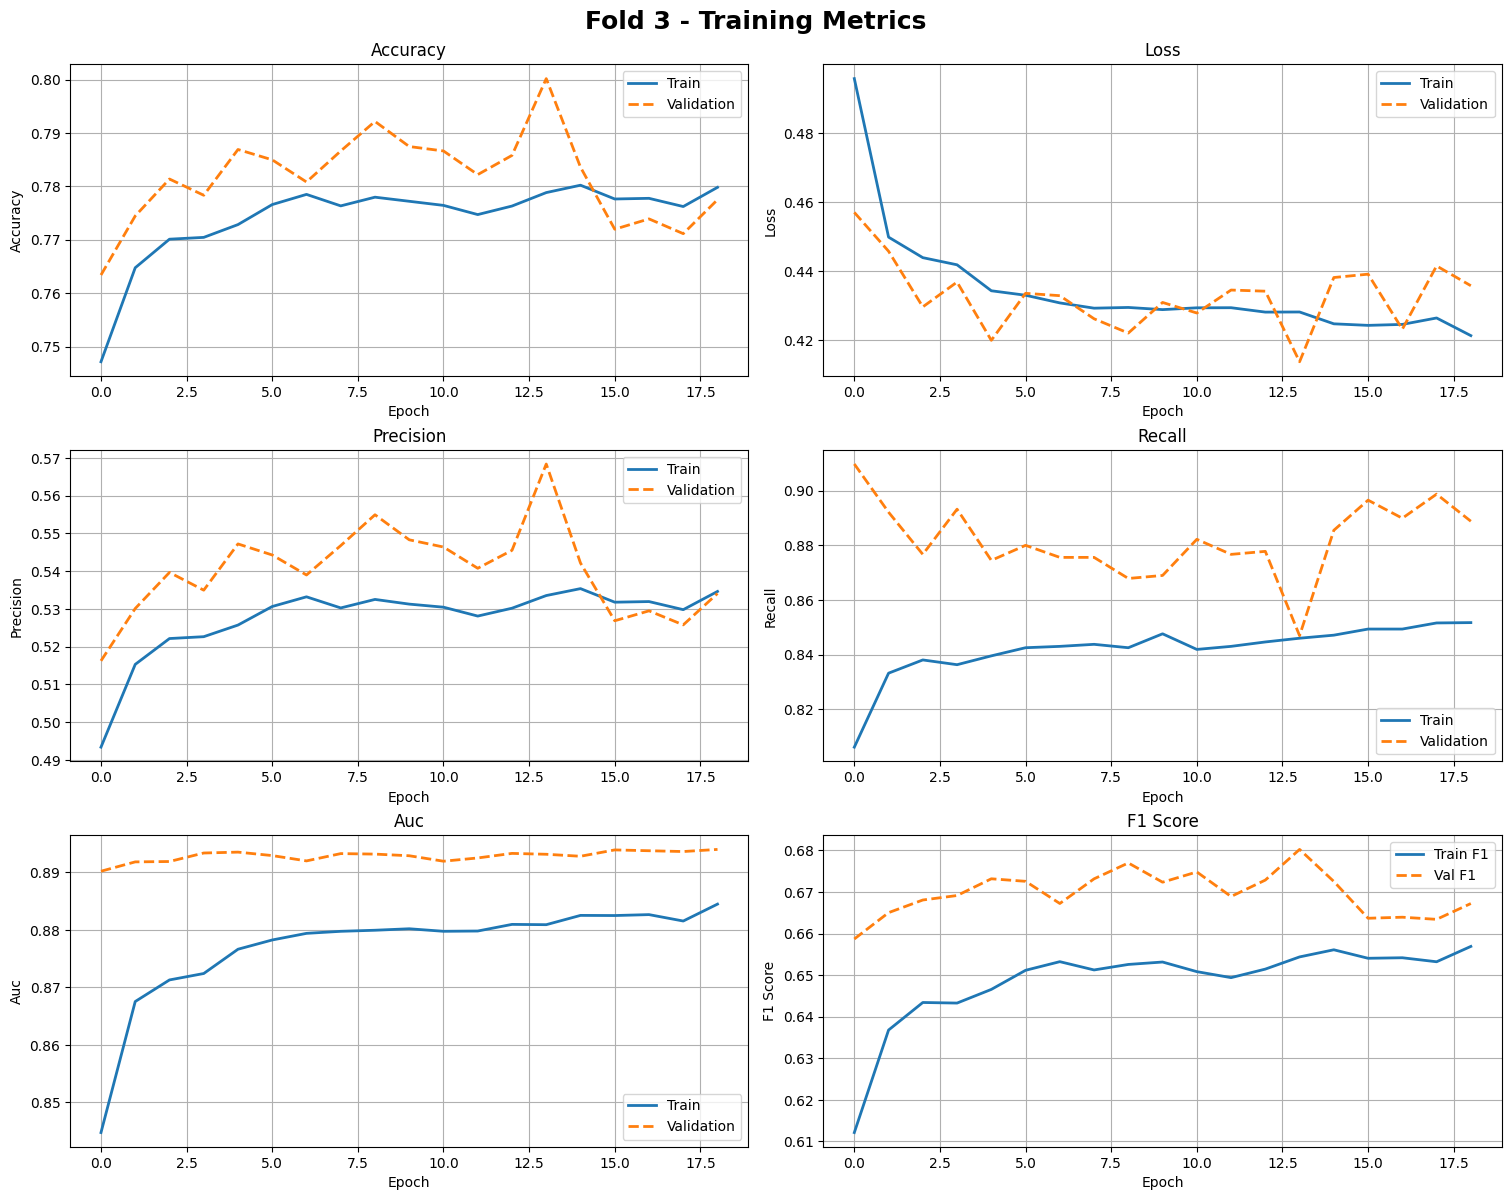

Fold 4 Training History


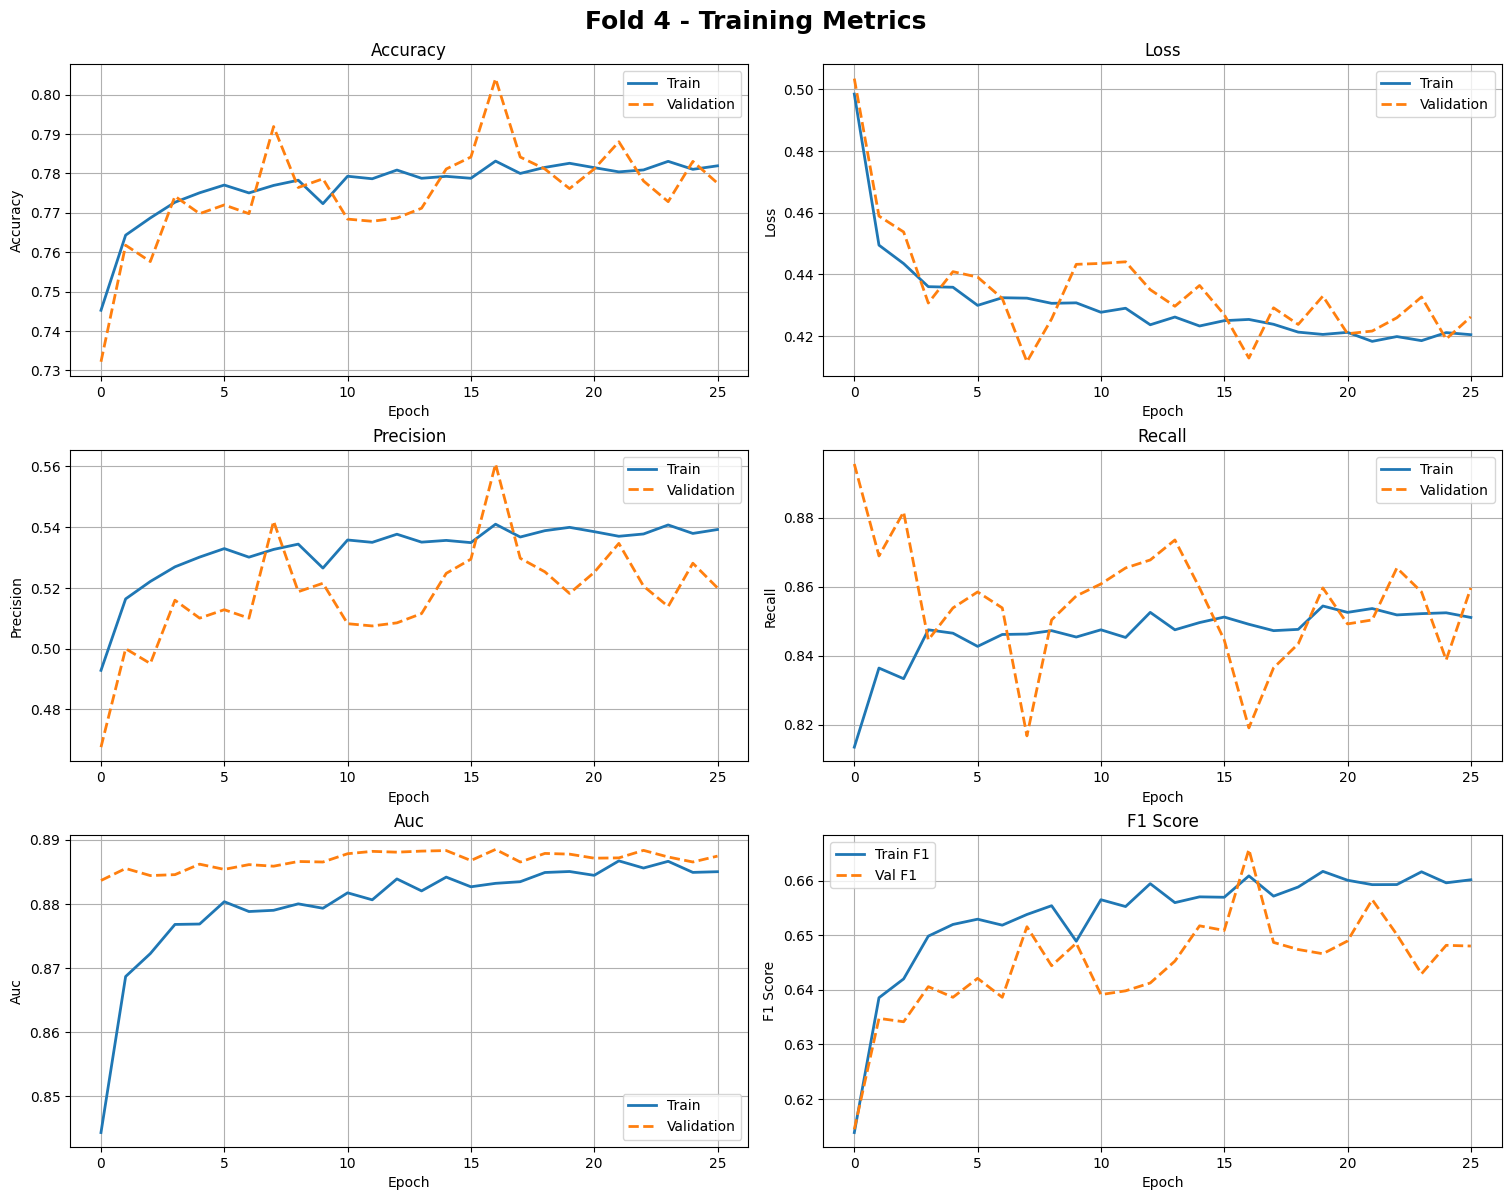

Fold 5 Training History


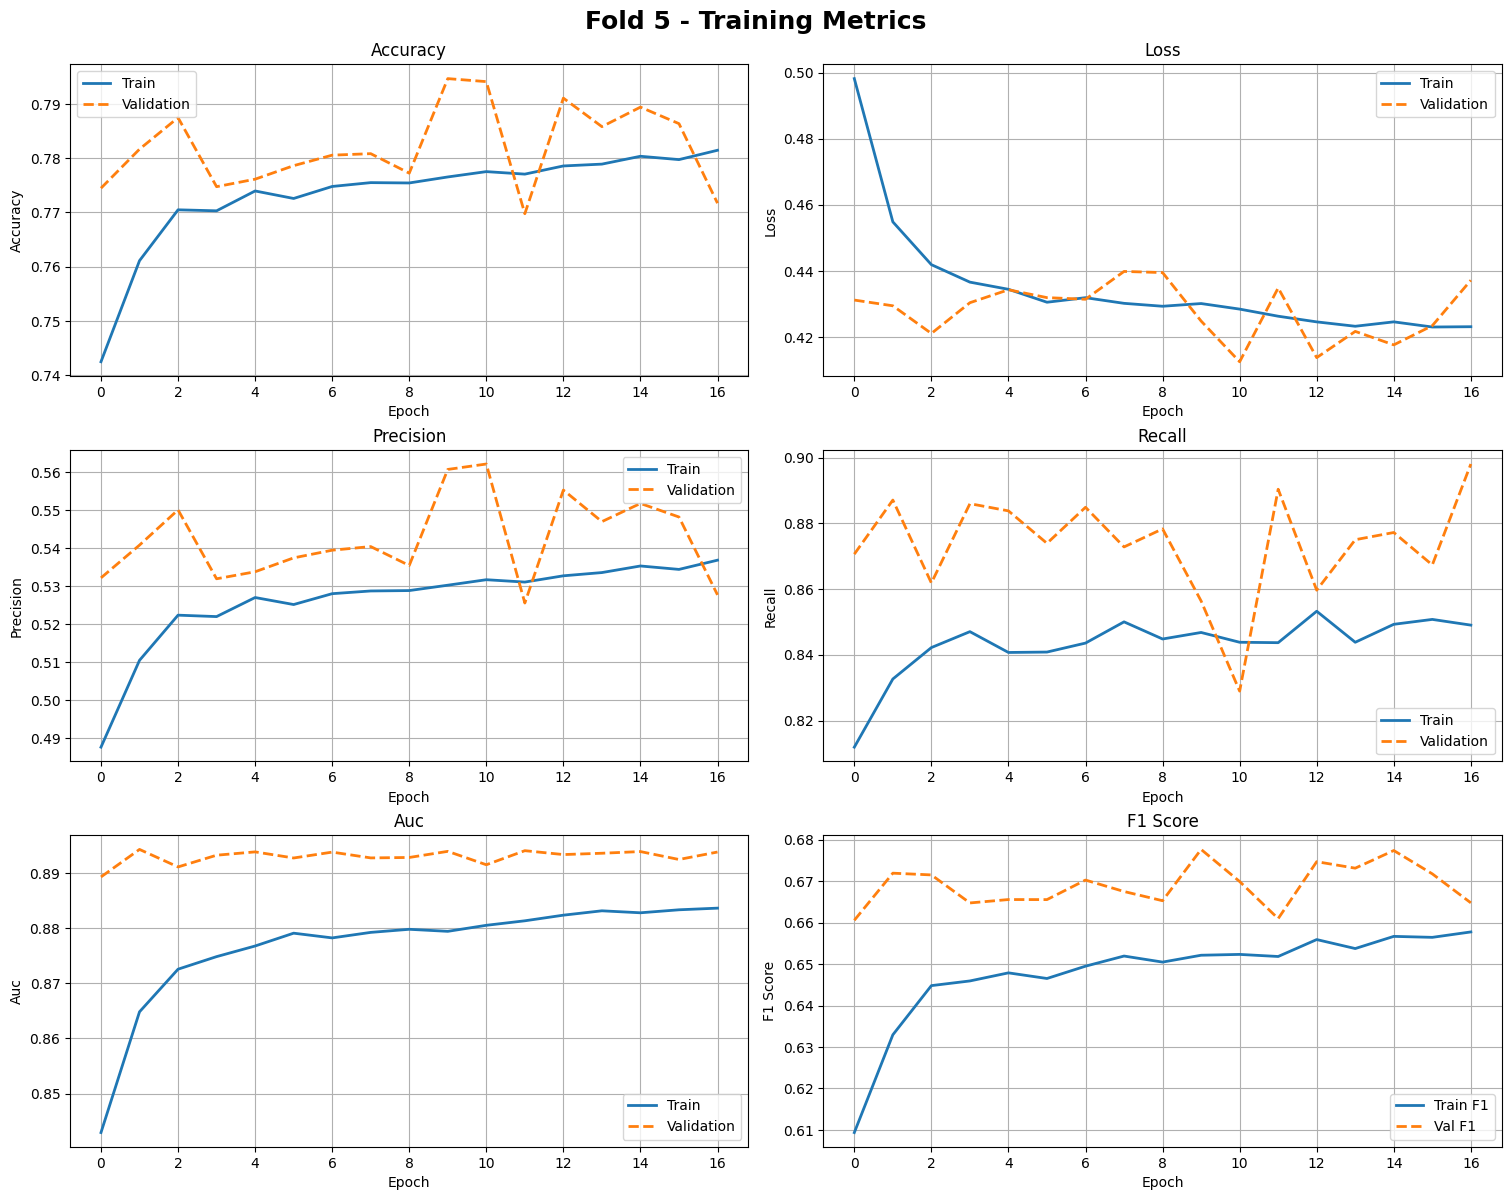

Fold 6 Training History


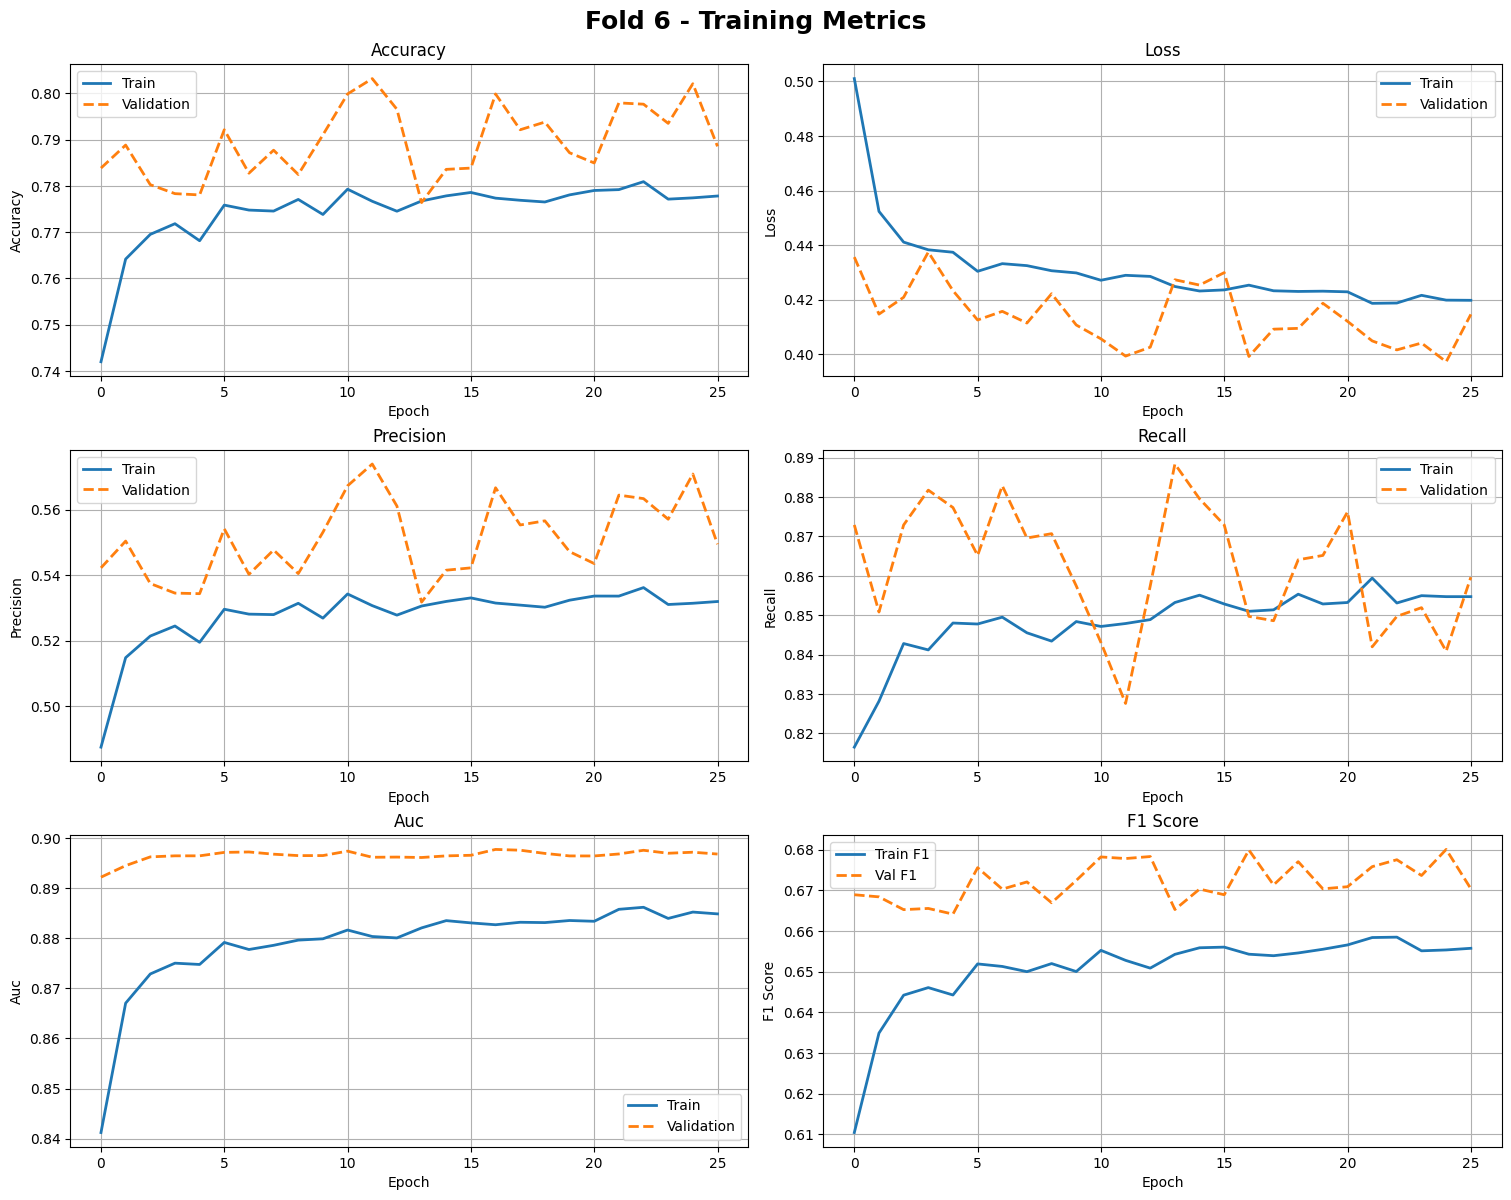

Fold 7 Training History


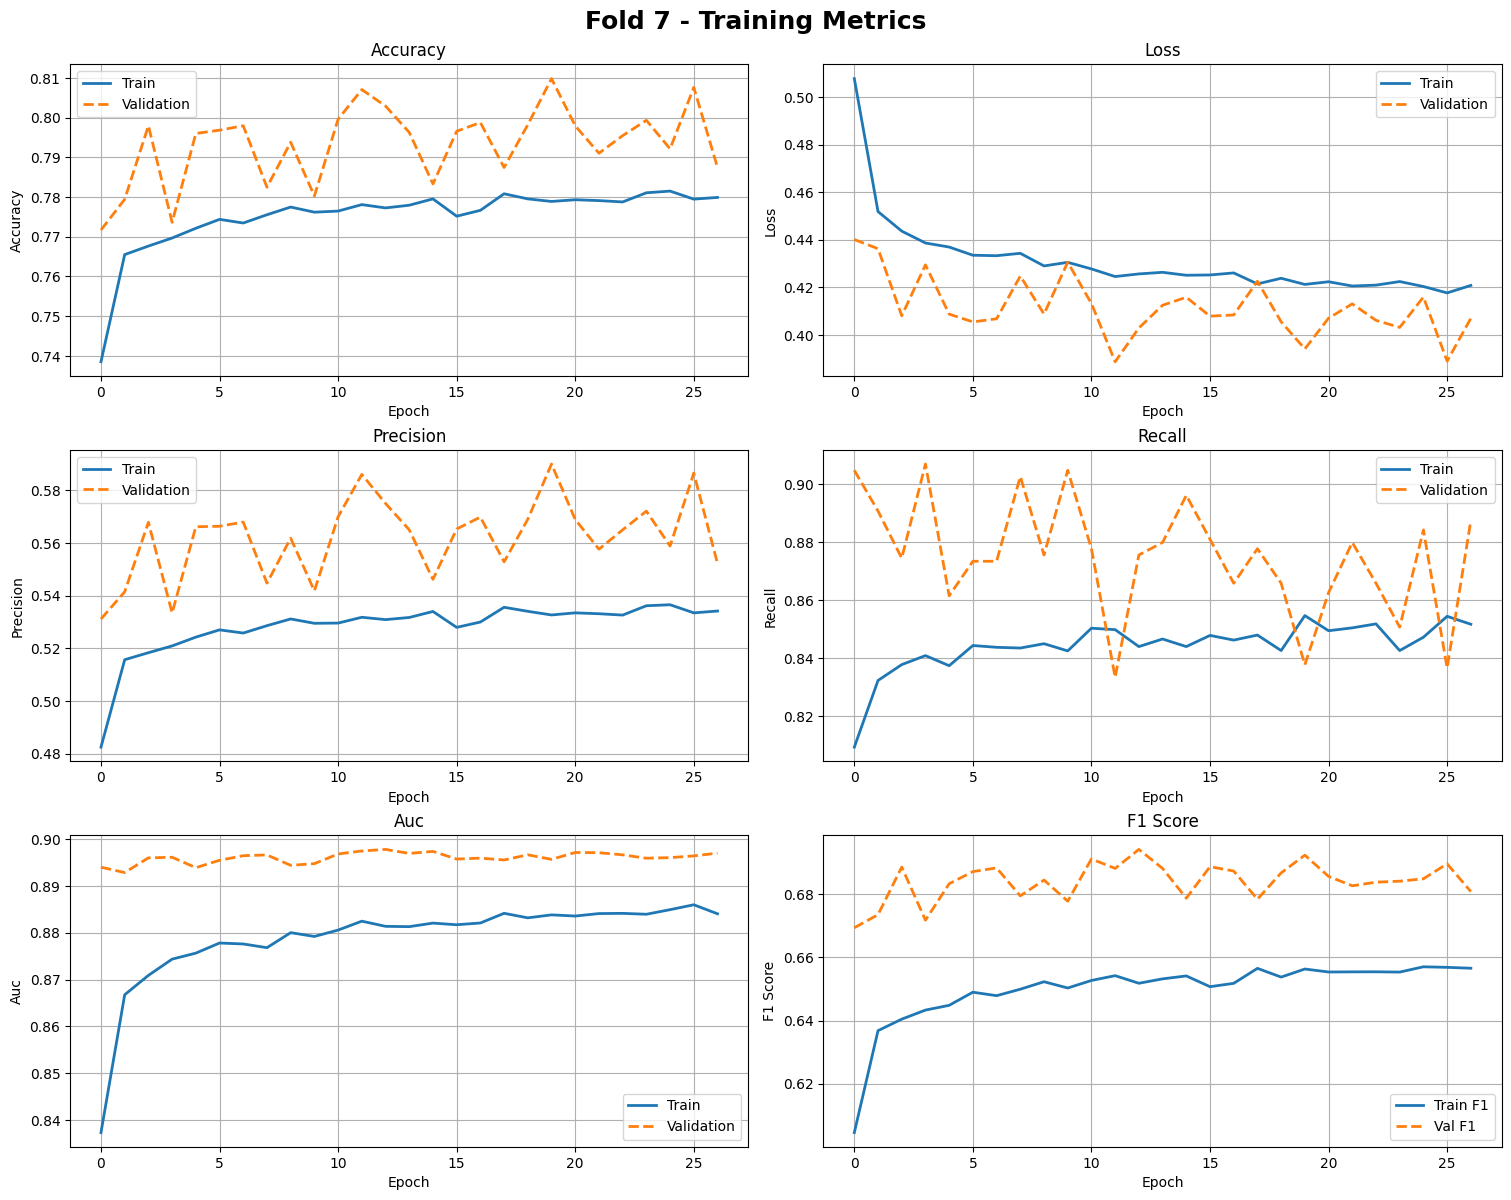

Fold 8 Training History


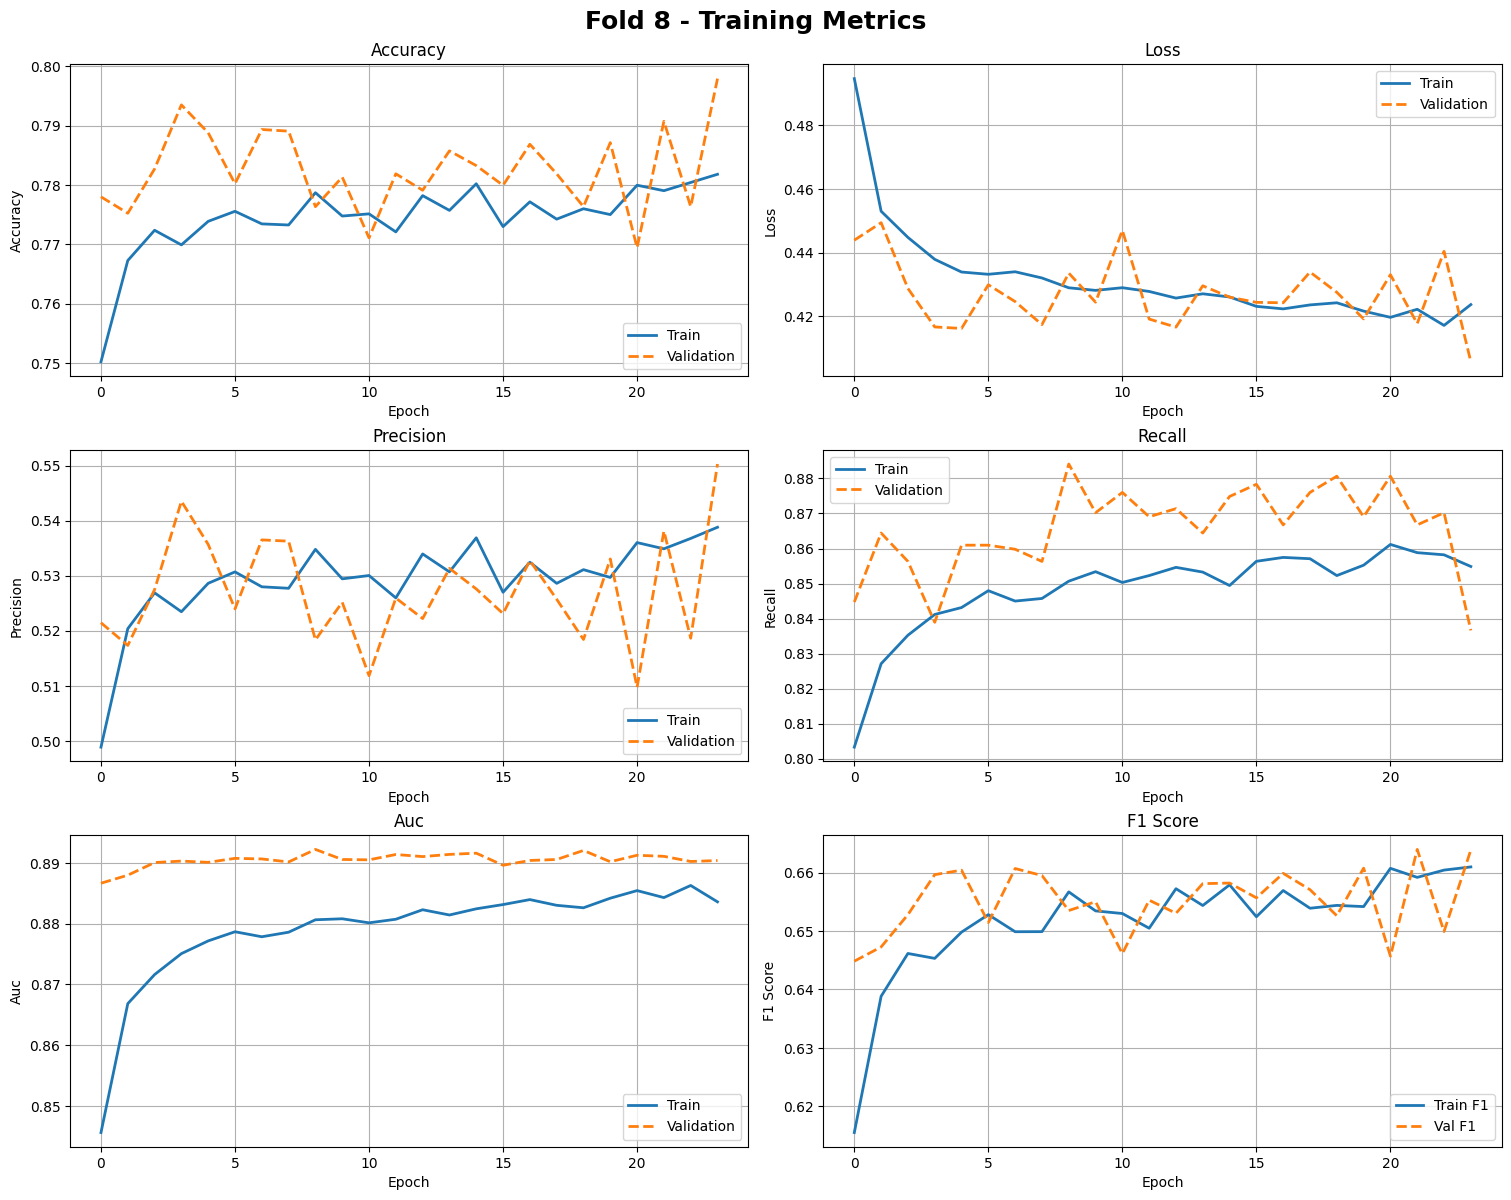

Fold 9 Training History


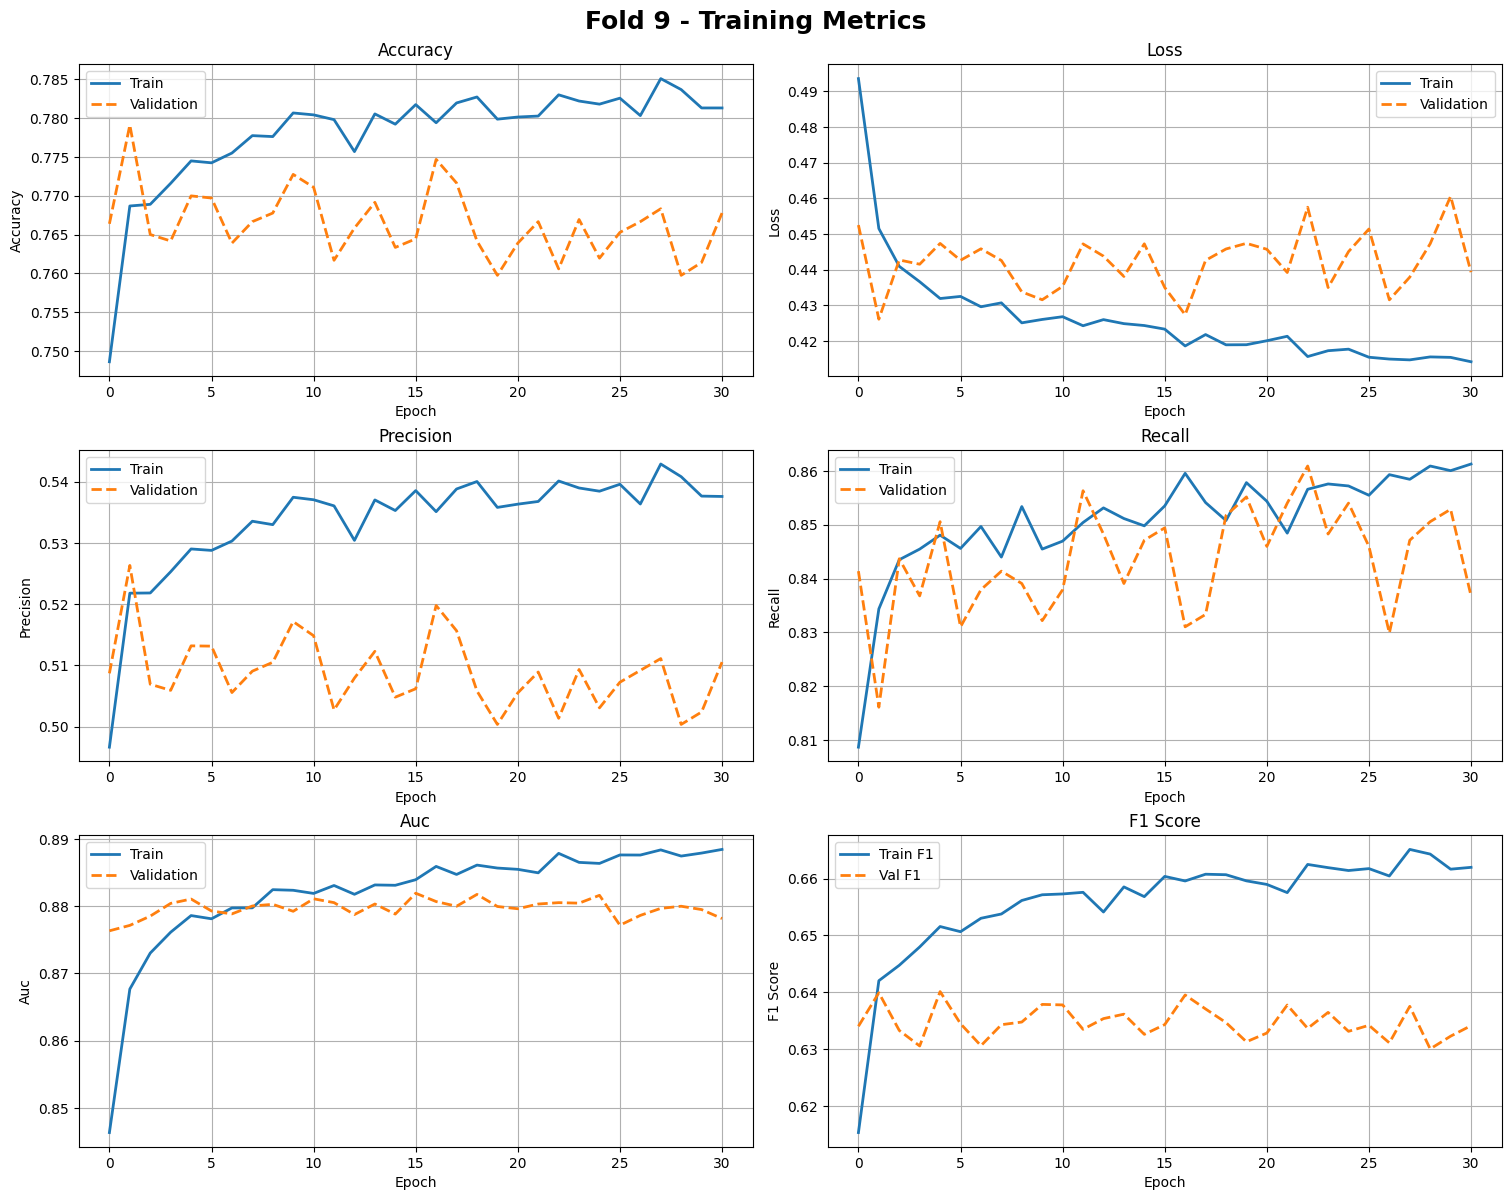

Fold 10 Training History


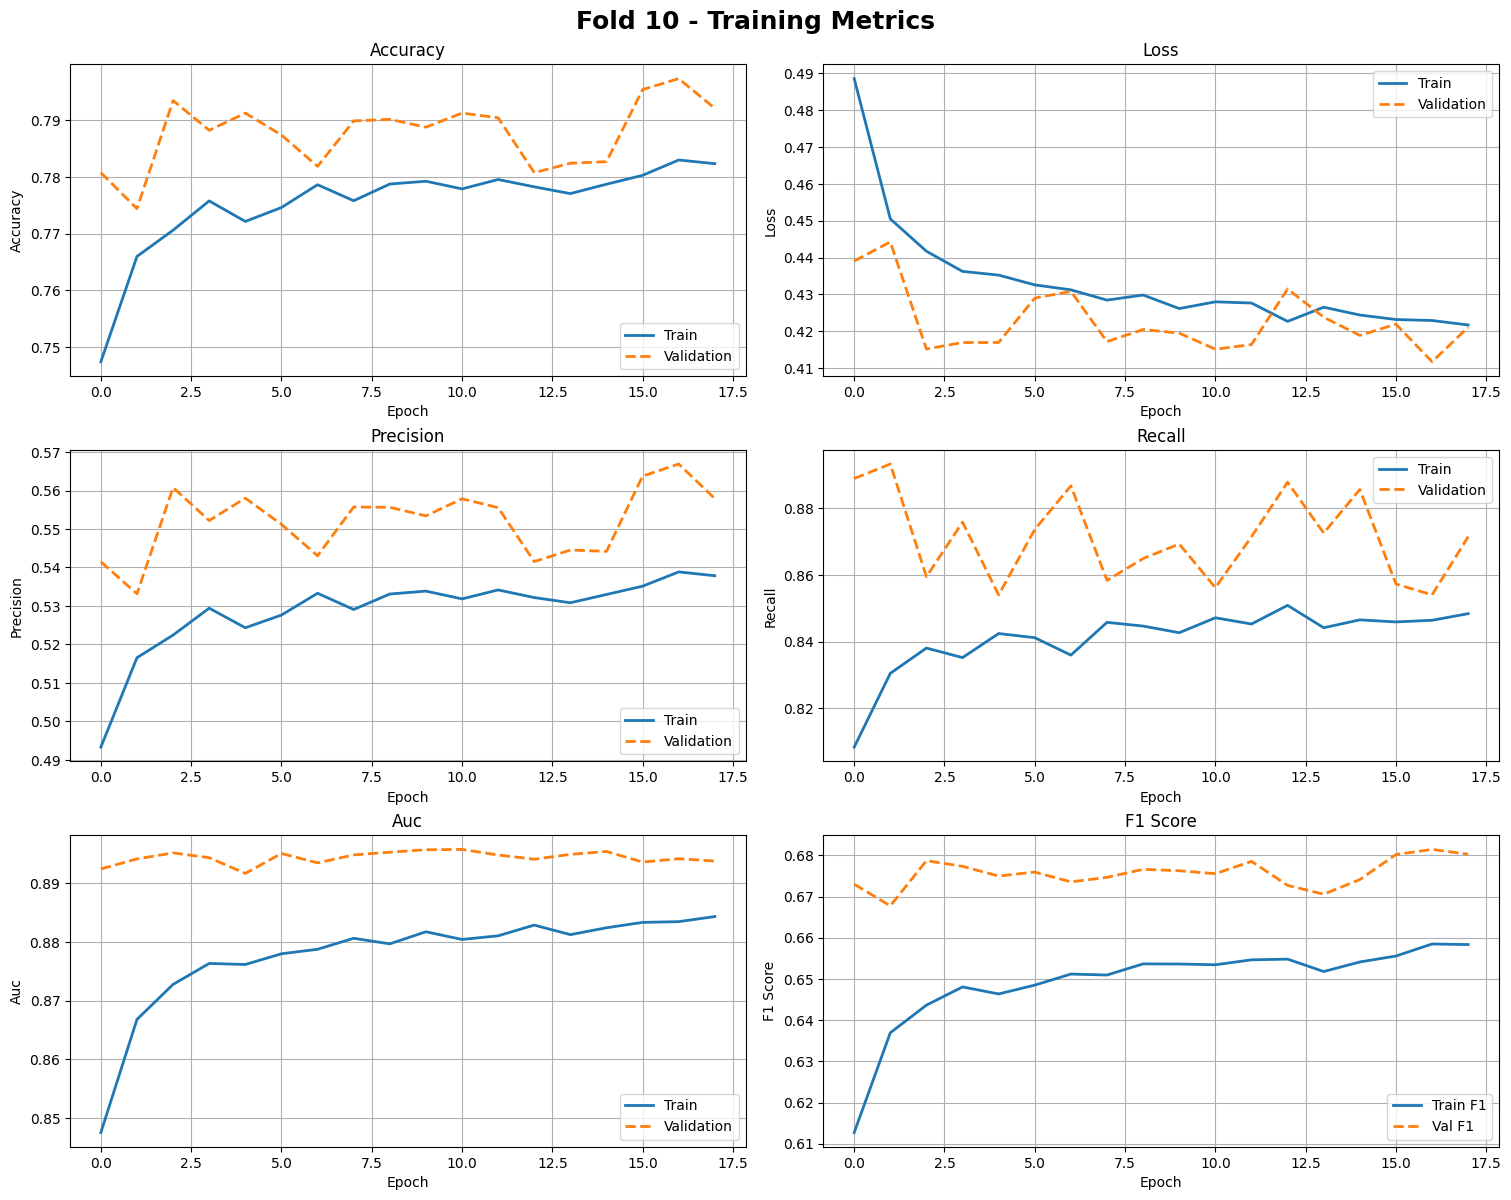

In [147]:
def compute_f1(precision, recall):
    return [2 * (p * r) / (p + r) if (p + r) > 0 else 0 for p, r in zip(precision, recall)]

for fold_num, history in fold_historys.items():
    print(f"Fold {fold_num} Training History")

    fig = plt.figure(figsize=(15, 15), constrained_layout=True)
    gs = fig.add_gridspec(4, 2)

    # Subplots for rows 1 to 3
    ax_accuracy = fig.add_subplot(gs[0, 0])
    ax_loss = fig.add_subplot(gs[0, 1])
    ax_precision = fig.add_subplot(gs[1, 0])
    ax_recall = fig.add_subplot(gs[1, 1])
    ax_auc = fig.add_subplot(gs[2, 0])
    ax_f1 = fig.add_subplot(gs[2, 1])
    # ax_gap = fig.add_subplot(gs[3, 0])      # ← Row 4 (AUC Gap) - Commented
    # ax_lr = fig.add_subplot(gs[3, 1])       # ← Row 4 (Learning Rate) - Commented

    # Standard metric plots
    base_metrics = [
        ('accuracy', ax_accuracy),
        ('loss', ax_loss),
        ('precision', ax_precision),
        ('recall', ax_recall),
        ('auc', ax_auc),
    ]

    for metric, ax in base_metrics:
        ax.plot(history[metric], label='Train', linewidth=2)
        ax.plot(history[f'val_{metric}'], label='Validation', linestyle='--', linewidth=2)
        ax.set_title(f'{metric.title()}')
        ax.set_xlabel('Epoch')
        ax.set_ylabel(metric.title())
        ax.legend()
        ax.grid(True)

    # F1 Score plot
    train_f1 = compute_f1(history['precision'], history['recall'])
    val_f1 = compute_f1(history['val_precision'], history['val_recall'])
    ax_f1.plot(train_f1, label='Train F1', linewidth=2)
    ax_f1.plot(val_f1, label='Val F1', linestyle='--', linewidth=2)
    ax_f1.set_title('F1 Score')
    ax_f1.set_xlabel('Epoch')
    ax_f1.set_ylabel('F1 Score')
    ax_f1.legend()
    ax_f1.grid(True)

    # AUC Gap Plot
    # auc_gap = [tr - val for tr, val in zip(history['auc'], history['val_auc'])]
    # ax_gap.plot(auc_gap, color='orange', label='AUC Gap (Train - Val)', linewidth=2)
    # ax_gap.axhline(0, color='gray', linestyle='--')
    # ax_gap.set_title('AUC Gap')
    # ax_gap.set_xlabel('Epoch')
    # ax_gap.set_ylabel('Gap')
    # ax_gap.legend()
    # ax_gap.grid(True)

    # Learning Rate Plot
    # if 'lr' in history:
    #     ax_lr.plot(history['lr'], label='Learning Rate', color='purple', linewidth=2)
    #     ax_lr.set_title('Learning Rate')
    #     ax_lr.set_xlabel('Epoch')
    #     ax_lr.set_ylabel('LR')
    #     ax_lr.legend()
    #     ax_lr.grid(True)
    # else:
    #     ax_lr.text(0.5, 0.5, 'No LR Data', ha='center', va='center', fontsize=12)
    #     ax_lr.set_title('Learning Rate')
    #     ax_lr.axis('off')

    fig.suptitle(f'Fold {fold_num} - Training Metrics', fontsize=18, fontweight='bold')
    plt.show()

In [148]:
# Average metrics
avg_metrics = {
    metric: np.mean([fold[metric] for fold in fold_metrics])
    for metric in ['accuracy', 'precision', 'recall', 'auc']
}

print('\nAverage metrics across all folds:')
print(f"Accuracy: {avg_metrics['accuracy']:.4f}")
print(f"Precision: {avg_metrics['precision']:.4f}")
print(f"Recall: {avg_metrics['recall']:.4f}")
print(f"AUC: {avg_metrics['auc']:.4f}")


Average metrics across all folds:
Accuracy: 0.7806
Precision: 0.5367
Recall: 0.8644
AUC: 0.8914


## Evaluation & Results

### Cross-Validation Performance

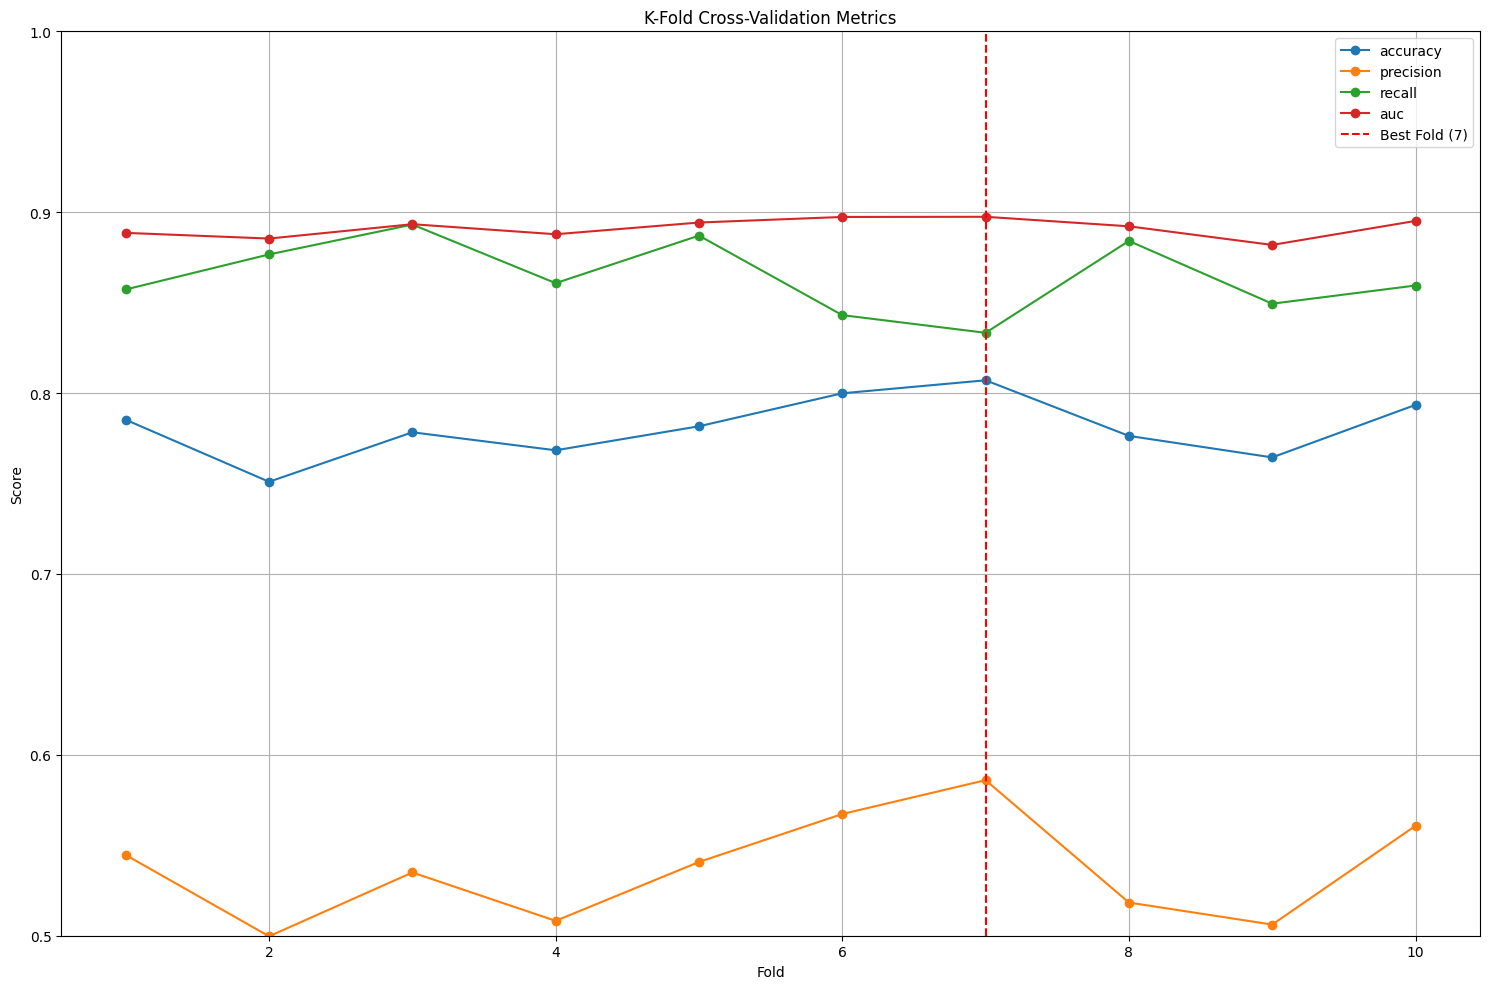

In [149]:
df_metrics = pd.DataFrame(fold_metrics) # Convert to DataFrame
plt.figure(figsize=(15, 10)) # Plotting
# df_metrics.plot(x='fold', y=['accuracy', 'precision', 'recall', 'auc'], kind='bar', figsize=(10, 5))
for metric in ['accuracy', 'precision', 'recall', 'auc']:
    plt.plot(df_metrics['fold'], df_metrics[metric], marker='o', label=metric)
plt.title('K-Fold Cross-Validation Metrics') # plt.title('Fold-wise Evaluation Metrics')
plt.axvline(best_fold_idx_number, color='red', linestyle='--', label=f'Best Fold ({best_fold_idx_number})')
plt.xlabel('Fold')
plt.ylabel('Score')
# plt.xticks(np.arange(len(df_metrics))) # plt.xticks(rotation=0)
plt.ylim(0.5, 1.0)
plt.grid(True) # plt.grid(axis='y')
plt.legend()
plt.tight_layout()
plt.show()

In [150]:
# Dynamic Interpretation
def interpret_kfold_metrics(df_metrics):
    interpretation = []
    interpretation.append("K-Fold Cross-Validation Metrics Summary")
    metrics = ['accuracy', 'precision', 'recall', 'auc']
    for metric in metrics:
        mean = df_metrics[metric].mean()
        std = df_metrics[metric].std()
        min_val = df_metrics[metric].min()
        max_val = df_metrics[metric].max()
        interpretation.append(f"\n{metric.capitalize()} Summary:")
        interpretation.append(f"- Mean: {mean:.4f}")
        interpretation.append(f"- Standard Deviation: {std:.4f}")
        interpretation.append(f"- Min: {min_val:.4f}, Max: {max_val:.4f}")
        if std < 0.015:
            interpretation.append("  The performance is highly consistent across folds.")
        elif std < 0.03:
            interpretation.append("  The model is reasonably stable across folds.")
        else:
            interpretation.append("  There is noticeable variation; fold-specific results should be reviewed.")
    return "\n".join(interpretation)
print(interpret_kfold_metrics(df_metrics))

K-Fold Cross-Validation Metrics Summary

Accuracy Summary:
- Mean: 0.7806
- Standard Deviation: 0.0169
- Min: 0.7510, Max: 0.8071
  The model is reasonably stable across folds.

Precision Summary:
- Mean: 0.5367
- Standard Deviation: 0.0288
- Min: 0.4997, Max: 0.5860
  The model is reasonably stable across folds.

Recall Summary:
- Mean: 0.8644
- Standard Deviation: 0.0200
- Min: 0.8333, Max: 0.8932
  The model is reasonably stable across folds.

Auc Summary:
- Mean: 0.8914
- Standard Deviation: 0.0052
- Min: 0.8819, Max: 0.8975
  The performance is highly consistent across folds.


In [151]:
# Report best fold
print(f"\nBest Model is from Fold {best_fold_idx_number} with AUC: {best_metric:.4f}")
best_model_path = f'{folder_path}/fold_{best_fold_idx_number}.keras'
final_model = load_model(best_model_path)


Best Model is from Fold 7 with AUC: 0.8975


### Model Architecture Summary

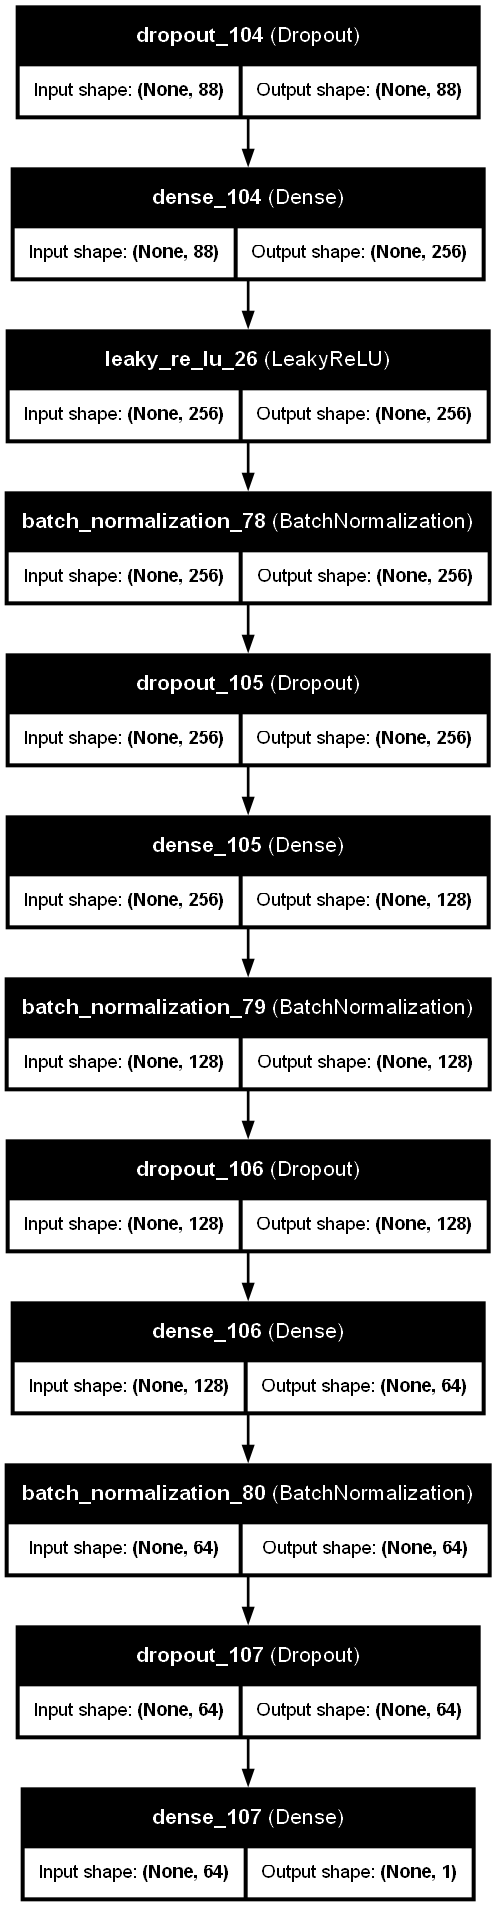

In [152]:
plot_model(
    final_model,
    to_file='ignore/model_plot.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96
)

In [153]:
final_model.summary()

Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_104 (Dropout)           │ (None, 88)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_104 (Dense)               │ (None, 256)            │        22,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_26 (LeakyReLU)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_78          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_105 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_105 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_79          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_106 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_106 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_80          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_107 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_107 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 195,589 (764.02 KB)

 Trainable params: 64,897 (253.50 KB)

 Non-trainable params: 896 (3.50 KB)

 Optimizer params: 129,796 (507.02 KB)

### Learning Curves

In [154]:
best_history = fold_historys[best_fold_idx_number - 1]
best_epoch_index = np.argmax(best_history['val_auc']) # Get metrics from best epoch

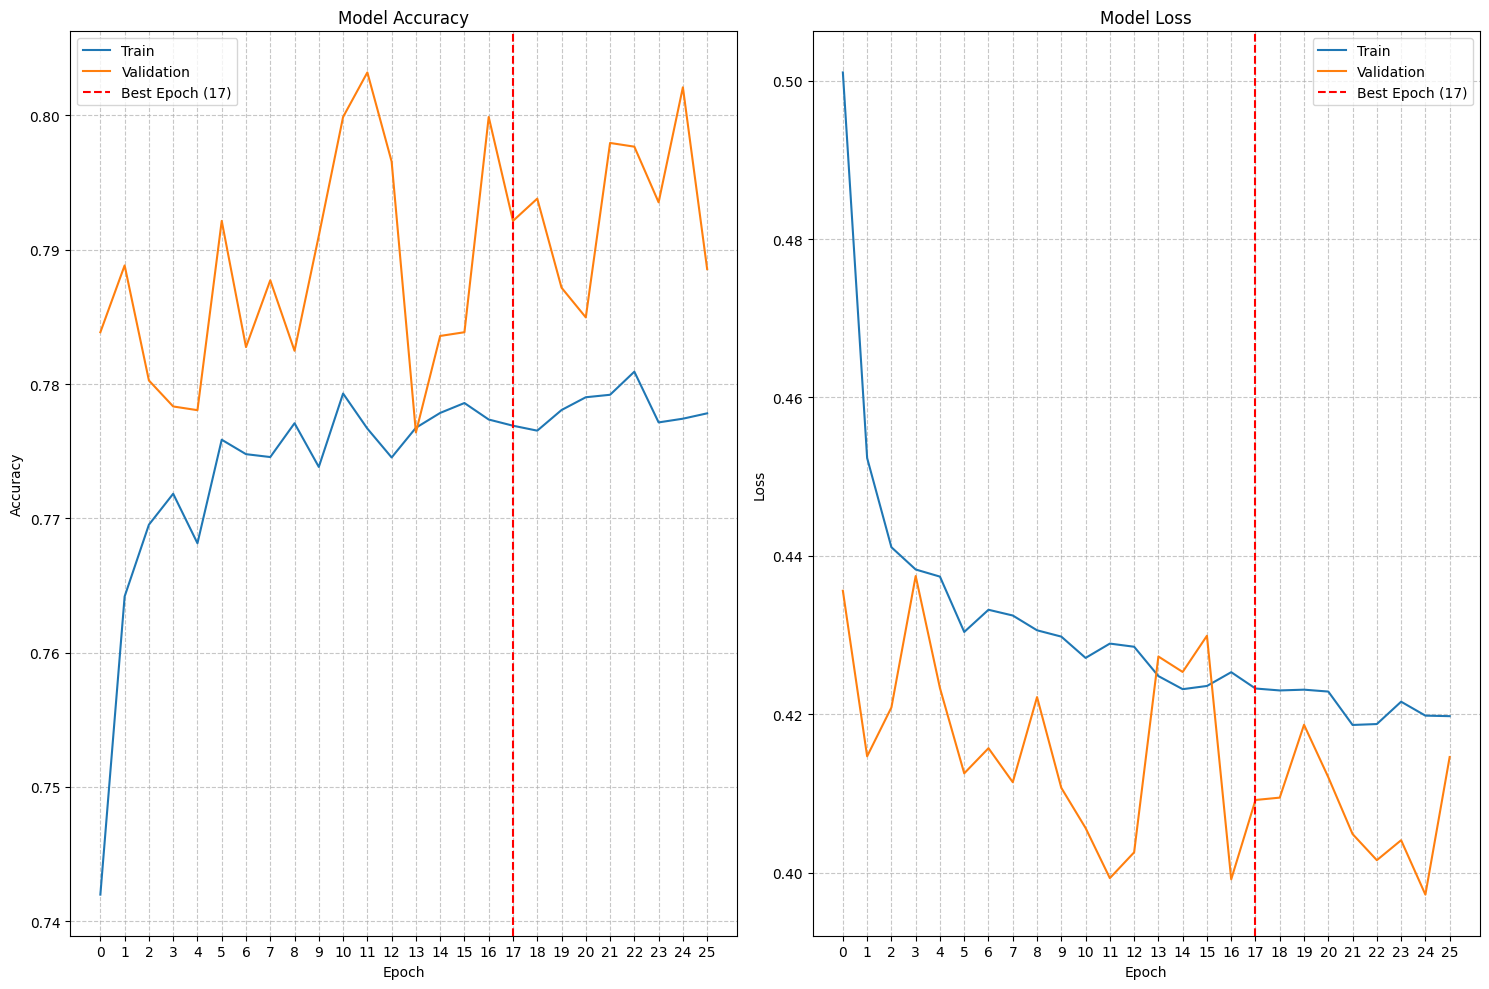

Training completed after 26 epochs
Best epoch based on val AUC: 17
Final training loss: 0.4197
Final training accuracy: 0.7778
Final validation loss: 0.4146
Final validation accuracy: 0.7886


In [155]:
plt.figure(figsize=(15, 10))
# # Accuracy curves
# plt.plot(best_history['accuracy'], label='Train Accuracy', color='blue')
# plt.plot(best_history['val_accuracy'], label='Validation Accuracy', color='blue', linestyle='--')
# # Loss curves (scaled to match accuracy axis)
# plt.plot(best_history['loss'], label='Train Loss', color='green')
# plt.plot(best_history['val_loss'], label='Validation Loss', color='green', linestyle='--')
# # Best epoch vertical line
# plt.axvline(best_epoch_index, color='red', linestyle='--', label=f'Best Epoch ({best_epoch_index})')
epochs = np.arange(len(best_history['accuracy']))
plt.subplot(1, 2, 1) # Plot training accuracy values
plt.plot(best_history['accuracy'], label='Train')
plt.plot(best_history['val_accuracy'], label='Validation')
plt.axvline(best_epoch_index + 1, color='red', linestyle='--', label=f'Best Epoch ({best_epoch_index + 1})')
plt.xticks(epochs)  # Set x-axis ticks to every epoch
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.subplot(1, 2, 2) # Plot training loss values
plt.plot(best_history['loss'], label='Train')
plt.plot(best_history['val_loss'], label='Validation')
plt.axvline(best_epoch_index + 1, color='red', linestyle='--', label=f'Best Epoch ({best_epoch_index + 1})')
plt.xticks(epochs)  # Set x-axis ticks to every epoch
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
# plt.title('Model Accuracy and Loss Over Epochs')
# plt.xlabel('Epoch')
# plt.ylabel('Metric Value')
# plt.legend()
# plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Print information about training
print(f"Training completed after {len(best_history['loss'])} epochs")
print(f"Best epoch based on val AUC: {best_epoch_index + 1}")
print(f"Final training loss: {best_history['loss'][-1]:.4f}")
print(f"Final training accuracy: {best_history['accuracy'][-1]:.4f}")
print(f"Final validation loss: {best_history['val_loss'][-1]:.4f}")
print(f"Final validation accuracy: {best_history['val_accuracy'][-1]:.4f}")


In [156]:
# Dynamic Interpetation
def interpret_learning_curves(history, best_epoch_index):
    interpretation = []
    interpretation.append("Training Curve Interpretation")
    num_epochs = len(history['loss'])
    final_train_acc = history['accuracy'][-1]
    final_val_acc = history['val_accuracy'][-1]
    final_train_loss = history['loss'][-1]
    final_val_loss = history['val_loss'][-1]
    interpretation.append(f"- Training completed over {num_epochs} epochs.")
    interpretation.append(f"- Final Training Accuracy: {final_train_acc:.4f}")
    interpretation.append(f"- Final Validation Accuracy: {final_val_acc:.4f}")
    interpretation.append(f"- Final Training Loss: {final_train_loss:.4f}")
    interpretation.append(f"- Final Validation Loss: {final_val_loss:.4f}")
    # Overfitting check
    if final_val_acc > final_train_acc and final_val_loss < final_train_loss:
        interpretation.append("\nThe validation accuracy is slightly higher than training accuracy, and validation loss is lower. This suggests that the model generalizes well.")
    elif final_val_acc < final_train_acc and final_val_loss > final_train_loss:
        interpretation.append("\nThere may be signs of overfitting, as validation accuracy is lower and validation loss is higher than training performance.")
    else:
        interpretation.append("\nTraining and validation curves appear fairly close, suggesting reasonable generalization.")
    interpretation.append(f"\nNOTE= Best epoch based on validation AUC: {best_epoch_index + 1}")
    return "\n".join(interpretation)
print(interpret_learning_curves(best_history, best_epoch_index))

Training Curve Interpretation
- Training completed over 26 epochs.
- Final Training Accuracy: 0.7778
- Final Validation Accuracy: 0.7886
- Final Training Loss: 0.4197
- Final Validation Loss: 0.4146

The validation accuracy is slightly higher than training accuracy, and validation loss is lower. This suggests that the model generalizes well.

NOTE= Best epoch based on validation AUC: 17


In [157]:
# Validation metrics at best epoch
val_accuracy = best_history['val_accuracy'][best_epoch_index]
val_precision = best_history['val_precision'][best_epoch_index]
val_recall = best_history['val_recall'][best_epoch_index]
val_auc = best_history['val_auc'][best_epoch_index]
val_loss = best_history['val_loss'][best_epoch_index]
# val_f1 = 2 * (val_precision * val_recall) / (val_precision + val_recall)

print("Best Epoch Number is:", best_epoch_index + 1, "\nfrom Fold Number", best_fold_idx_number)

Best Epoch Number is: 17 
from Fold Number 7


### Final Test Set Evaluation

In [158]:
# Preprocess the test set
X_test_processed = preprocessor.transform(X_test).astype('float32')
# Predict and evaluate
y_test_pred_probs = final_model.predict(X_test_processed).flatten()
y_test_pred = (y_test_pred_probs > 0.5).astype("int32") # Convert probabilities to binary predictions
y_test_pred

283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


array([0, 1, 0, ..., 0, 1, 1], dtype=int32)

### Get test scores

In [159]:
test_loss = final_model.evaluate(X_test_processed, y_test, verbose=0)[0]
test_accuracy = accuracy_score(y_test, y_test_pred) # final_model.evaluate(X_test_processed, y_test, verbose=0)[1]
test_precision = precision_score(y_test, y_test_pred) # final_model.evaluate(X_test_processed, y_test, verbose=0)[2]
test_recall = recall_score(y_test, y_test_pred) # final_model.evaluate(X_test_processed, y_test, verbose=0)[3]
test_auc = roc_auc_score(y_test, y_test_pred_probs) # final_model.evaluate(X_test_processed, y_test, verbose=0)[4]
# test_f1 = f1_score(y_test, y_test_pred)

In [160]:
cm = confusion_matrix(y_test, y_test_pred)
cr = classification_report(y_test, y_test_pred, output_dict=True)
cr_df = pd.DataFrame(cr).transpose()
precision, recall, thresholds = precision_recall_curve(y_test, y_test_pred_probs)
average_precision = average_precision_score(y_test, y_test_pred_probs)

In [161]:
metrics = {
    "Accuracy": {
        "VALIDATION": val_accuracy,
        "TEST": test_accuracy
    },
    "Precision": {
        "VALIDATION": val_precision,
        "TEST": test_precision
    },
    "Recall": {
        "VALIDATION": val_recall,
        "TEST": test_recall
    },
    "AUC": {
        "VALIDATION": val_auc,
        "TEST": test_auc
    },
    "Loss": {
        "VALIDATION": val_loss,
        "TEST": test_loss
    }
    # "F1": {
    #     "VALIDATION": val_f1,
    #     "TEST": test_f1
    # }
}
print(json.dumps(metrics, indent=4))

{
    "Accuracy": {
        "VALIDATION": 0.7998894453048706,
        "TEST": 0.7858485351022665
    },
    "Precision": {
        "VALIDATION": 0.5666912198066711,
        "TEST": 0.5436587460635557
    },
    "Recall": {
        "VALIDATION": 0.849723756313324,
        "TEST": 0.8470115967885816
    },
    "AUC": {
        "VALIDATION": 0.8977136611938477,
        "TEST": 0.8921880833126699
    },
    "Loss": {
        "VALIDATION": 0.3991425633430481,
        "TEST": 0.41314783692359924
    }
}


### Plotting the metrics to Check for Overfitting

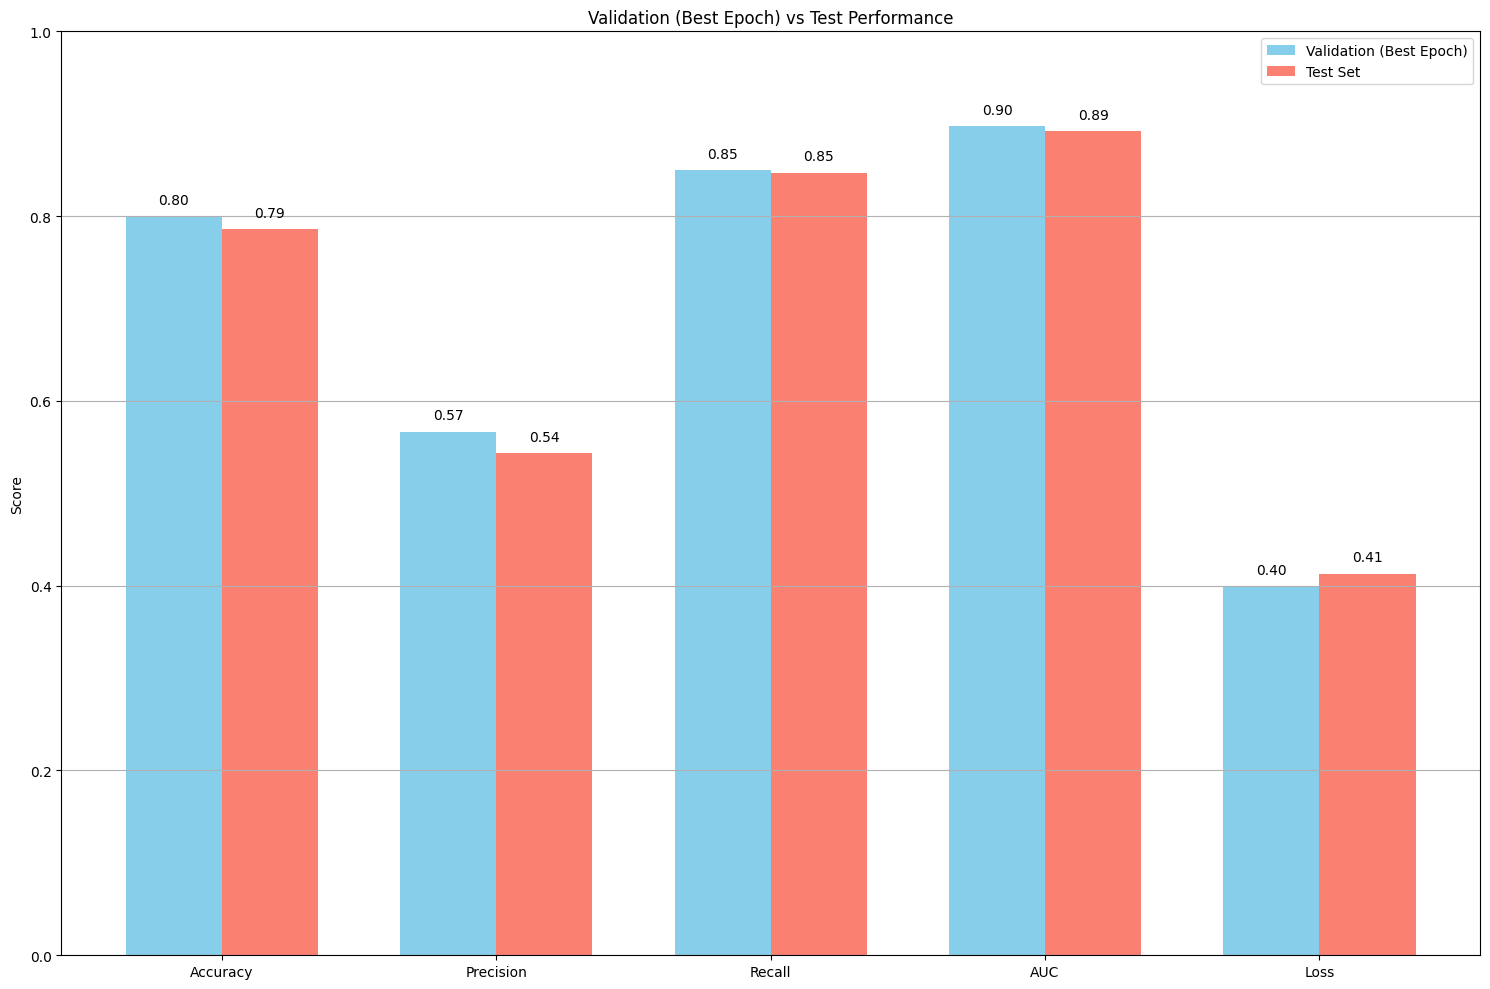

In [162]:
# Extract values for plotting
metric_names = list(metrics.keys())
val_scores = [metrics[m]["VALIDATION"] for m in metric_names]
test_scores = [metrics[m]["TEST"] for m in metric_names]

# Positioning and bar plot setup
x = np.arange(len(metrics))
width = 0.35
plt.figure(figsize=(15, 10))
# Plotting the bars
bars1 = plt.bar(x - width/2, val_scores, width, label='Validation (Best Epoch)', color='skyblue')
bars2 = plt.bar(x + width/2, test_scores, width, label='Test Set', color='salmon')
# Plot customization
plt.ylabel('Score')
plt.title('Validation (Best Epoch) vs Test Performance')
plt.xticks(x, metrics)
plt.ylim(0, 1 if max(max(val_scores), max(test_scores)) <= 1 else max(max(val_scores), max(test_scores)) + 0.1)
plt.legend()
plt.grid(axis='y')
# Annotate bars with values
for i in range(len(metrics)):
    plt.text(x[i] - width/2, val_scores[i] + 0.01, f"{val_scores[i]:.2f}", ha='center', va='bottom')
    plt.text(x[i] + width/2, test_scores[i] + 0.01, f"{test_scores[i]:.2f}", ha='center', va='bottom')
plt.tight_layout()
plt.show()

In [163]:
# Dynamic Interpretation
def generate_interpretation(metrics):
    interpretation = []
    interpretation.append("Validation vs Test Performance Interpretation =")
    for metric, scores in metrics.items():
        val = scores["VALIDATION"]
        test = scores["TEST"]
        diff = val - test
        direction = (
            "higher" if val > test else
            "lower" if val < test else
            "equal"
        )
        interpretation.append(
            f"- {metric}: Validation score is {val:.2f}, Test score is {test:.2f} — Test is {direction} by {abs(diff):.2f}."
        )
    # Simple overfitting logic: if more than 2 metrics have validation > test by 0.02
    overfitting_flags = sum(
        1 for m in metrics if metrics[m]["VALIDATION"] - metrics[m]["TEST"] > 0.02
    )
    if overfitting_flags >= 2:
        interpretation.append(
            "\nHENCE:\tPotential Overfitting Detected - "
            "Several validation scores are notably higher than test scores, "
            "suggesting the model may have learned patterns specific to the validation set "
            "that do not generalize well."
        )
    else:
        interpretation.append(
            "\nHENCE:\tNo Major Overfitting - The performance across validation and test sets "
            "is consistent, indicating good generalization."
        )
    return "\n".join(interpretation)
print(generate_interpretation(metrics))

Validation vs Test Performance Interpretation =
- Accuracy: Validation score is 0.80, Test score is 0.79 — Test is higher by 0.01.
- Precision: Validation score is 0.57, Test score is 0.54 — Test is higher by 0.02.
- Recall: Validation score is 0.85, Test score is 0.85 — Test is higher by 0.00.
- AUC: Validation score is 0.90, Test score is 0.89 — Test is higher by 0.01.
- Loss: Validation score is 0.40, Test score is 0.41 — Test is lower by 0.01.

HENCE:	No Major Overfitting - The performance across validation and test sets is consistent, indicating good generalization.


### Confusion Matrix Visualization

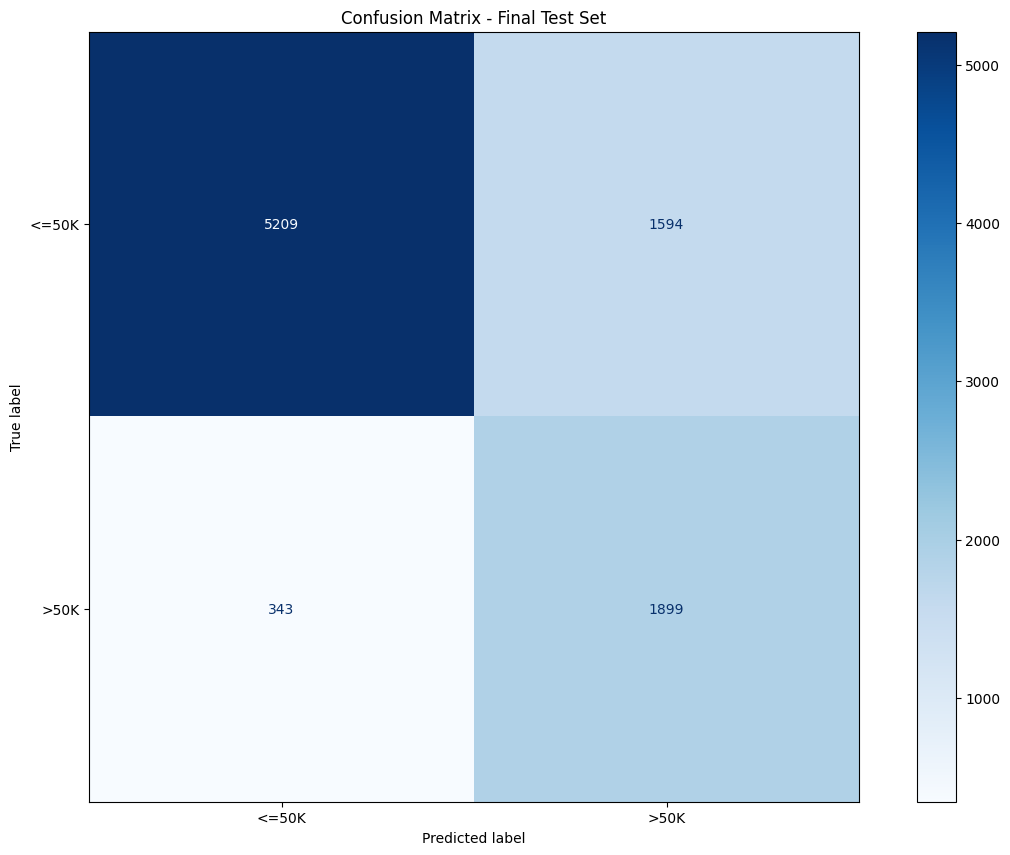

In [164]:
fig, ax = plt.subplots(figsize=(15, 10))  # Adjust size as needed
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['<=50K', '>50K']) # Confusion Matrix
disp.plot(cmap=plt.cm.Blues, values_format='d', ax=ax) # Display the confusion matrix
plt.title("Confusion Matrix - Final Test Set")
plt.grid(False)
plt.show()

In [165]:
# Dynamic Interpretation
def interpret_confusion_matrix(cm, labels=["<=50K", ">50K"]):
    tn, fp, fn, tp = cm.ravel()  # Unpack confusion matrix
    interpretation = []
    interpretation.append("Confusion Matrix Interpretation – Final Test Set")
    interpretation.append(f"- True Negatives ({labels[0]} predicted correctly): {tn}")
    interpretation.append(f"- False Positives ({labels[0]} misclassified as {labels[1]}): {fp}")
    interpretation.append(f"- False Negatives ({labels[1]} misclassified as {labels[0]}): {fn}")
    interpretation.append(f"- True Positives ({labels[1]} predicted correctly): {tp}")
    # Optional derived metrics
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
    interpretation.append("\nKey Metrics")
    interpretation.append(f"- Accuracy: {accuracy:.2f}")
    interpretation.append(f"- Precision: {precision:.2f}")
    interpretation.append(f"- Recall: {recall:.2f}")
    interpretation.append(f"- F1 Score: {f1:.2f}")
    # Bias comment
    if recall > precision + 0.1:
        interpretation.append("\nThe model is more recall-focused, meaning it catches more of the >50K cases, but may include more false positives.")
    elif precision > recall + 0.1:
        interpretation.append("\nThe model is more precision-focused, meaning it's careful when predicting >50K but may miss many true >50K cases.")
    else:
        interpretation.append("\nThe model has a balanced precision-recall tradeoff.")
    return "\n".join(interpretation)
print(interpret_confusion_matrix(cm))

Confusion Matrix Interpretation – Final Test Set
- True Negatives (<=50K predicted correctly): 5209
- False Positives (<=50K misclassified as >50K): 1594
- False Negatives (>50K misclassified as <=50K): 343
- True Positives (>50K predicted correctly): 1899

Key Metrics
- Accuracy: 0.79
- Precision: 0.54
- Recall: 0.85
- F1 Score: 0.66

The model is more recall-focused, meaning it catches more of the >50K cases, but may include more false positives.


### Per-Class Performance Metrics

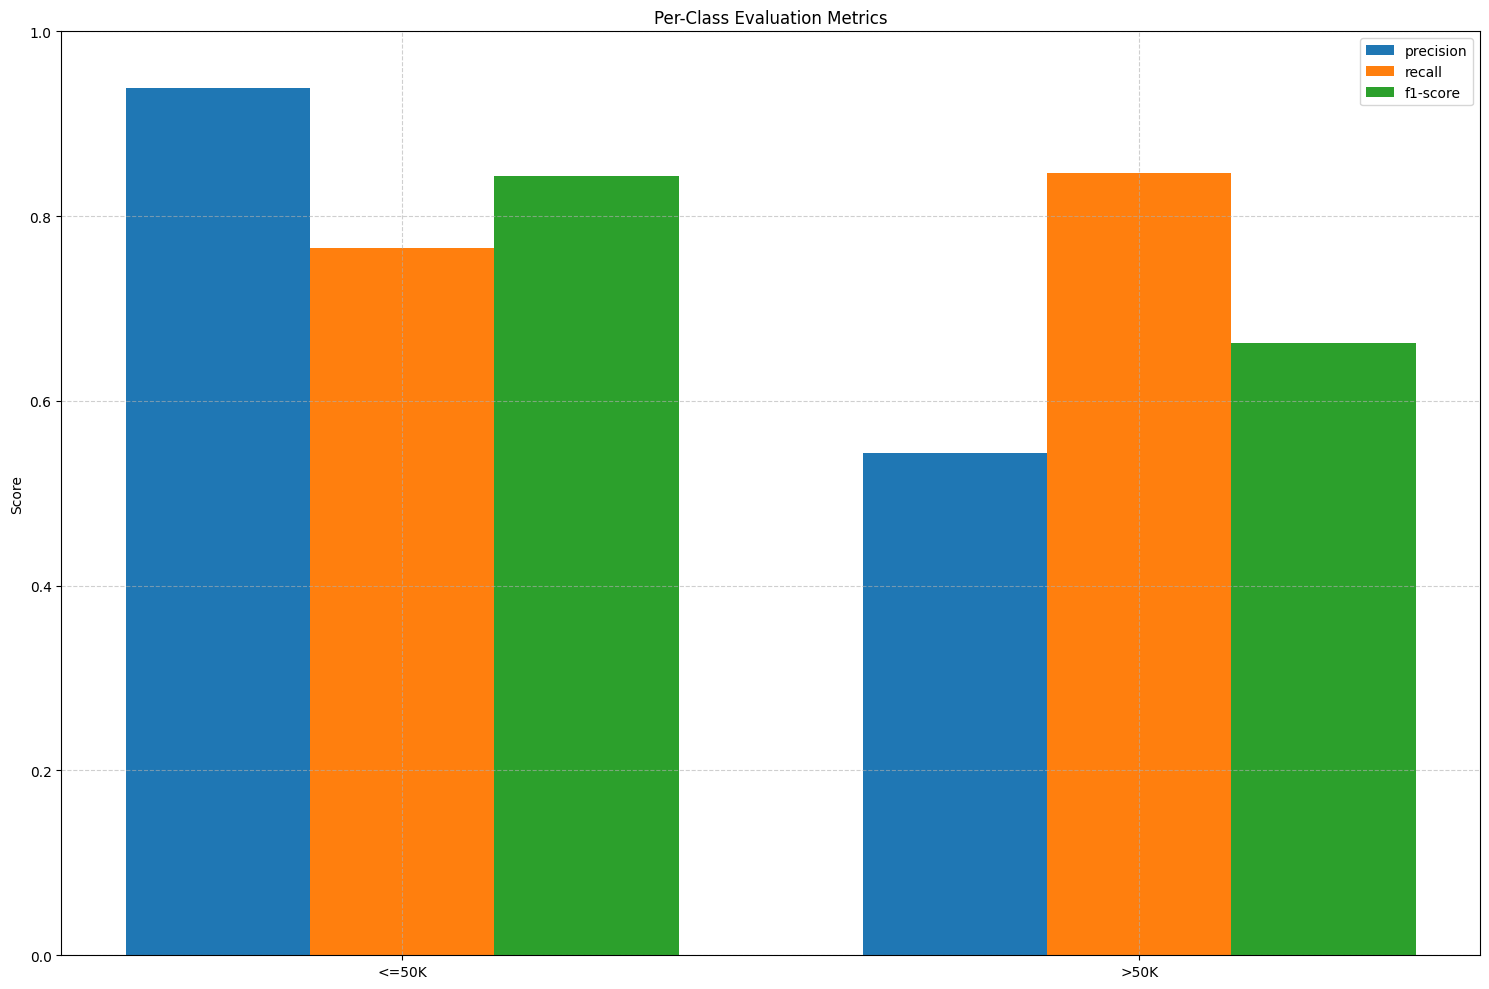

In [166]:
classes = ['<=50K', '>50K']
metrics = ['precision', 'recall', 'f1-score']
plt.figure(figsize=(15, 10))
for i, metric in enumerate(metrics):
    values = [cr[str(cls)][metric] for cls in [0, 1]]
    plt.bar([x + i*0.25 for x in range(len(classes))], values, width=0.25, label=metric)
plt.xticks([x + 0.25 for x in range(len(classes))], classes)
plt.ylabel("Score")
plt.title("Per-Class Evaluation Metrics")
plt.ylim(0, 1)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

In [167]:
# Dynamic Interpretation
def interpret_per_class_metrics(cr, labels=["<=50K", ">50K"]):
    interpretation = []
    interpretation.append("Per-Class Evaluation Metrics Interpretation")
    for i, label in enumerate(labels):
        class_report = cr[str(i)]
        precision = class_report.get("precision", 0)
        recall = class_report.get("recall", 0)
        f1 = class_report.get("f1-score", 0)
        interpretation.append(f"\nClass: {label}")
        interpretation.append(f"- Precision: {precision:.2f}")
        interpretation.append(f"- Recall: {recall:.2f}")
        interpretation.append(f"- F1 Score: {f1:.2f}")
        if recall > precision + 0.1:
            interpretation.append("  The model is more focused on capturing this class, but may include more false positives.")
        elif precision > recall + 0.1:
            interpretation.append("  The model is more conservative when predicting this class, possibly missing valid cases.")
        else:
            interpretation.append("  The model shows a good balance between precision and recall.")
    return "\n".join(interpretation)
print(interpret_per_class_metrics(cr, classes))

Per-Class Evaluation Metrics Interpretation

Class: <=50K
- Precision: 0.94
- Recall: 0.77
- F1 Score: 0.84
  The model is more conservative when predicting this class, possibly missing valid cases.

Class: >50K
- Precision: 0.54
- Recall: 0.85
- F1 Score: 0.66
  The model is more focused on capturing this class, but may include more false positives.


### Plotting the Confusion Matrix as a heatmap

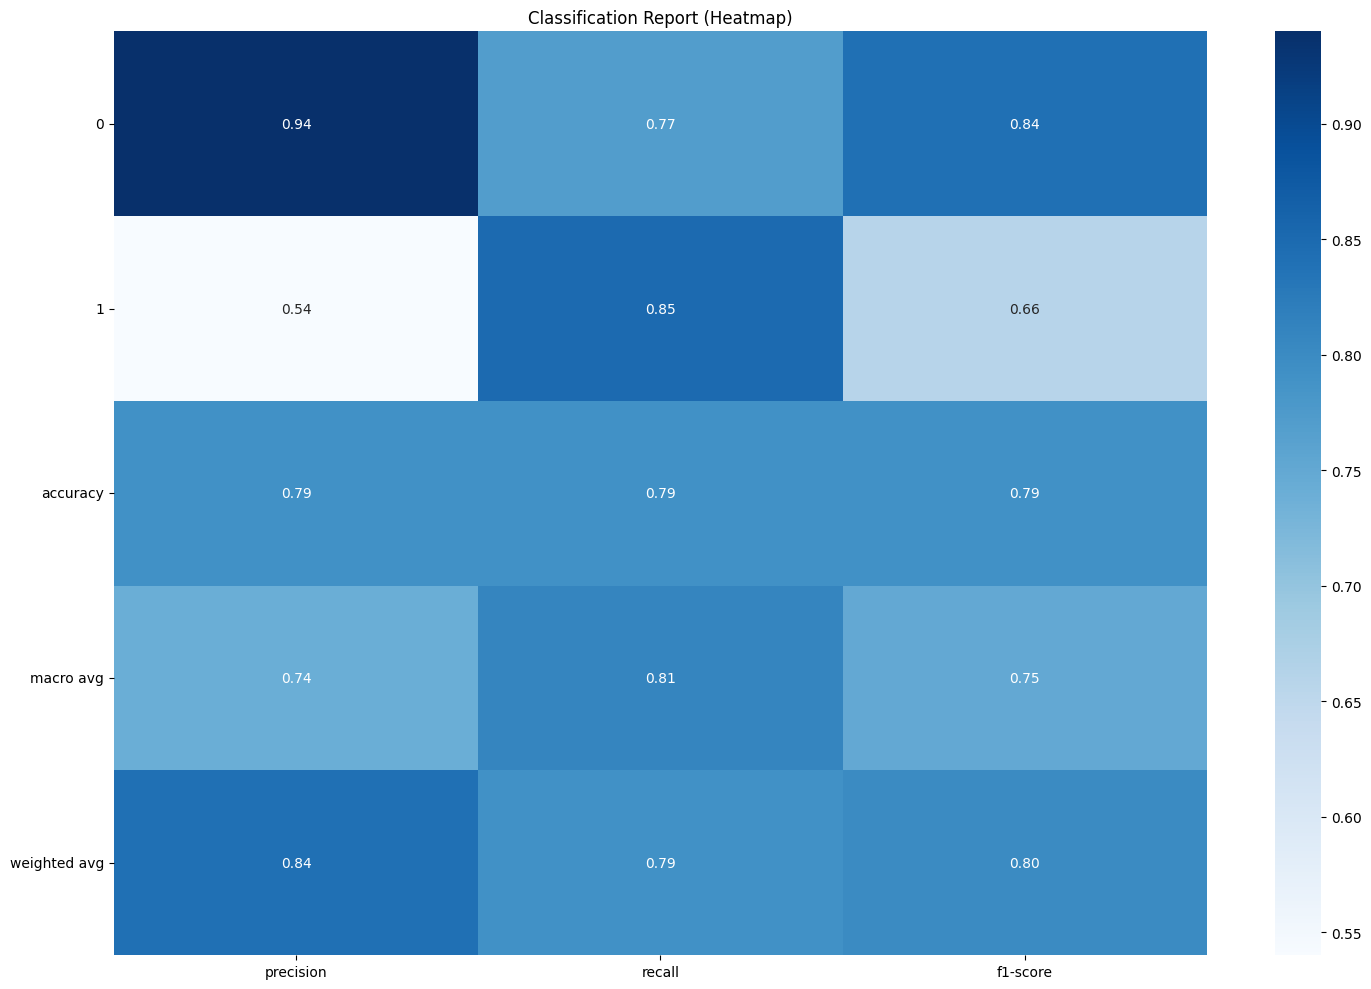

In [168]:
# cr_df = cr_df.drop(['accuracy', 'macro avg', 'weighted avg'], errors='ignore') # Drop 'accuracy', 'macro avg', 'weighted avg' if needed
cr_df = cr_df.round(2) # Optional: round to 2 decimals for cleaner heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(cr_df.iloc[:, :-1], annot=True, cmap='Blues', cbar=True, fmt='.2f')
plt.title("Classification Report (Heatmap)")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [169]:
# Dynamic Interpretation
def interpret_classification_report(cr, labels=["0", "1"]):
    interpretation = []
    interpretation.append("Classification Report Summary")
    # Individual class performance
    for label in labels:
        precision = cr[label]["precision"]
        recall = cr[label]["recall"]
        f1 = cr[label]["f1-score"]
        interpretation.append(f"\nClass {label} Metrics:")
        interpretation.append(f"- Precision: {precision:.2f}")
        interpretation.append(f"- Recall: {recall:.2f}")
        interpretation.append(f"- F1 Score: {f1:.2f}")
        if recall > precision + 0.1:
            interpretation.append("  The model focuses more on identifying this class, but it may generate more false positives.")
        elif precision > recall + 0.1:
            interpretation.append("  The model is cautious in predicting this class, possibly missing true positives.")
        else:
            interpretation.append("  Precision and recall are balanced for this class.")
    # Overall performance
    interpretation.append("\nOverall Metrics:")
    accuracy = cr["accuracy"]
    macro_avg = cr["macro avg"]
    weighted_avg = cr["weighted avg"]
    interpretation.append(f"- Accuracy: {accuracy:.2f}")
    interpretation.append(f"- Macro Avg Precision: {macro_avg['precision']:.2f}, Recall: {macro_avg['recall']:.2f}, F1 Score: {macro_avg['f1-score']:.2f}")
    interpretation.append(f"- Weighted Avg Precision: {weighted_avg['precision']:.2f}, Recall: {weighted_avg['recall']:.2f}, F1 Score: {weighted_avg['f1-score']:.2f}")
    # Class imbalance comment
    if abs(cr["0"]["recall"] - cr["1"]["recall"]) > 0.15:
        interpretation.append("\nThere may be class imbalance or difficulty in predicting one class compared to the other.")
    else:
        interpretation.append("\nThe model handles both classes fairly evenly.")
    return "\n".join(interpretation)
print(interpret_classification_report(cr))

Classification Report Summary

Class 0 Metrics:
- Precision: 0.94
- Recall: 0.77
- F1 Score: 0.84
  The model is cautious in predicting this class, possibly missing true positives.

Class 1 Metrics:
- Precision: 0.54
- Recall: 0.85
- F1 Score: 0.66
  The model focuses more on identifying this class, but it may generate more false positives.

Overall Metrics:
- Accuracy: 0.79
- Macro Avg Precision: 0.74, Recall: 0.81, F1 Score: 0.75
- Weighted Avg Precision: 0.84, Recall: 0.79, F1 Score: 0.80

The model handles both classes fairly evenly.


### ROC Curve Analysis

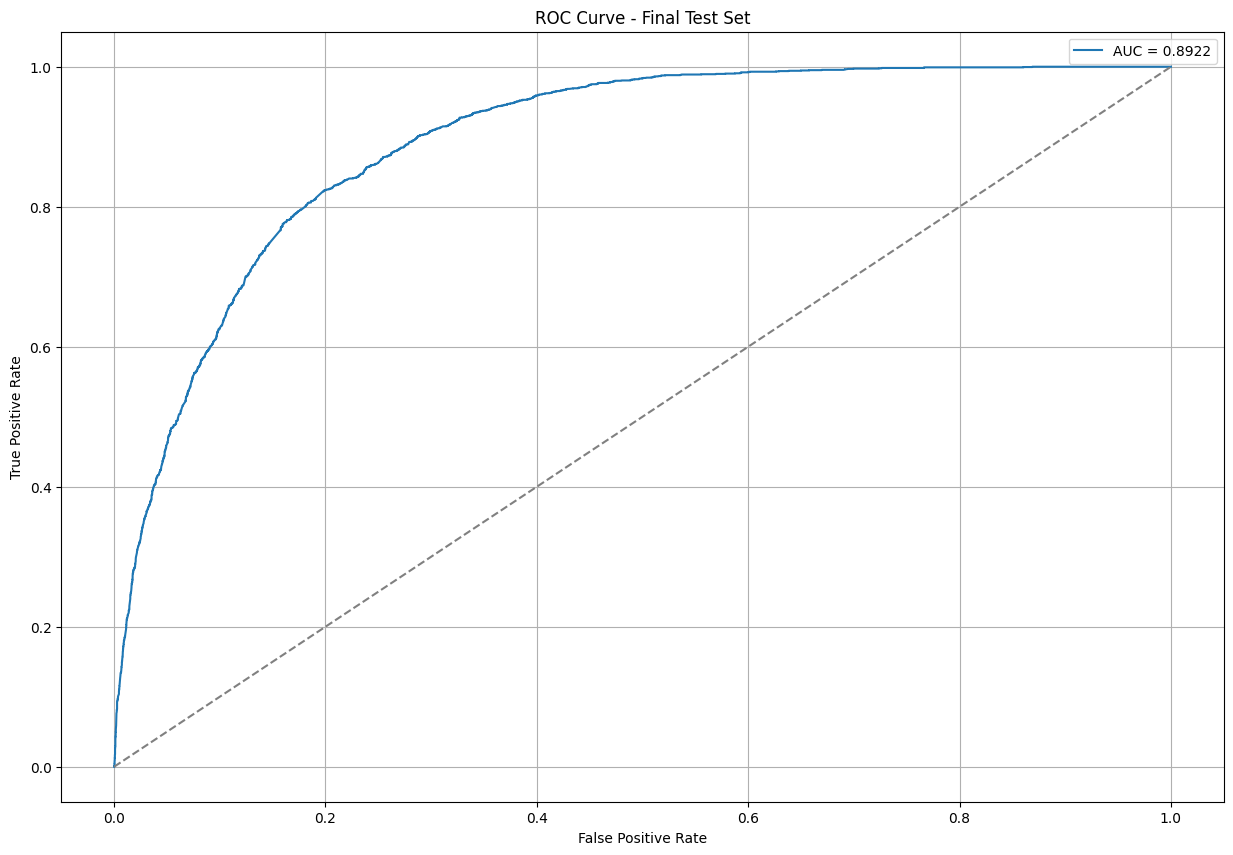

In [170]:
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_probs)
plt.figure(figsize=(15, 10))
plt.plot(fpr, tpr, label=f"AUC = {test_auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Final Test Set")
plt.legend()
plt.grid(True)
plt.show()

In [171]:
# Dynamic Interpretation
def interpret_roc_curve(test_auc):
    interpretation = []
    interpretation.append("ROC Curve Interpretation – Final Test Set")
    interpretation.append(f"- The Area Under the ROC Curve (AUC) is {test_auc:.4f}.")
    if test_auc >= 0.90:
        interpretation.append("  This is considered excellent. The model has a strong ability to distinguish between the two classes.")
    elif test_auc >= 0.80:
        interpretation.append("  This is considered very good. The model performs well in differentiating between the two classes.")
    elif test_auc >= 0.70:
        interpretation.append("  This is considered fair. The model has a moderate level of separability.")
    else:
        interpretation.append("  The model has poor separability and may not generalize well.")
    interpretation.append("  The curve bows well above the diagonal line, indicating that the model performs significantly better than random guessing.")
    return "\n".join(interpretation)
print(interpret_roc_curve(test_auc))  # Replace with your actual AUC

ROC Curve Interpretation – Final Test Set
- The Area Under the ROC Curve (AUC) is 0.8922.
  This is considered very good. The model performs well in differentiating between the two classes.
  The curve bows well above the diagonal line, indicating that the model performs significantly better than random guessing.


### Precision-Recall Curve

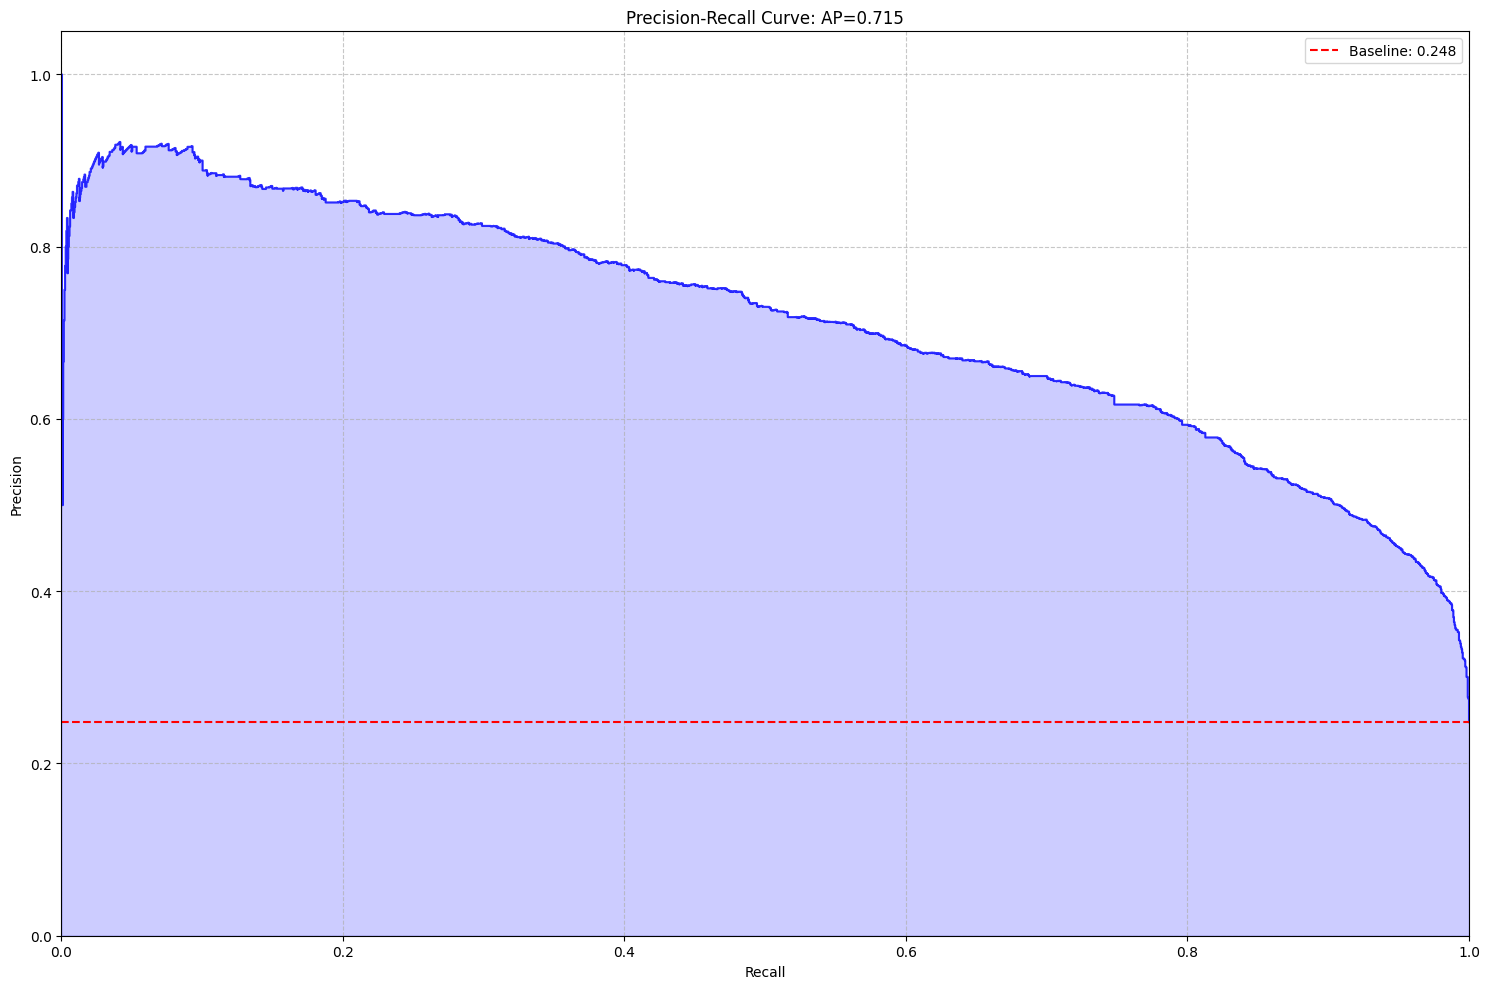

Average Precision Score: 0.7148


In [172]:
# Plot precision-recall curve
plt.figure(figsize=(15, 10))
plt.step(recall, precision, color='b', alpha=0.8, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(f'Precision-Recall Curve: AP={average_precision:.3f}')
plt.grid(True, linestyle='--', alpha=0.7)
baseline = len(y_test[y_test==1]) / len(y_test)  # No skill: positive class proportion
plt.axhline(y=baseline, color='r', linestyle='--', label=f'Baseline: {baseline:.3f}')
plt.legend()
plt.tight_layout()
plt.show()
print(f"Average Precision Score: {average_precision:.4f}")

In [173]:
# Dynamic Interpretation
def interpret_precision_recall_curve(average_precision, baseline):
    interpretation = []
    interpretation.append("Precision-Recall Curve Interpretation – Final Test Set")
    interpretation.append(f"- Average Precision (AP) score is {average_precision:.3f}.")
    interpretation.append(f"- Baseline (positive class ratio) is approximately {baseline:.3f}.")
    if average_precision >= 0.8:
        interpretation.append("  The model maintains high precision across a wide range of recall values, indicating strong performance.")
    elif average_precision >= 0.7:
        interpretation.append("  The model performs well, with a good balance between precision and recall.")
    elif average_precision >= 0.6:
        interpretation.append("  The model is acceptable, but may need tuning to improve precision or recall.")
    else:
        interpretation.append("  The model struggles to maintain precision as recall increases.")
    if average_precision > baseline + 0.3:
        interpretation.append("  The model performs significantly better than a no-skill classifier.")
    elif average_precision > baseline + 0.1:
        interpretation.append("  The model shows improvement over baseline, but may need optimization.")
    else:
        interpretation.append("  The model performs only slightly better than a no-skill classifier.")
    return "\n".join(interpretation)
print(interpret_precision_recall_curve(average_precision, baseline))

Precision-Recall Curve Interpretation – Final Test Set
- Average Precision (AP) score is 0.715.
- Baseline (positive class ratio) is approximately 0.248.
  The model performs well, with a good balance between precision and recall.
  The model performs significantly better than a no-skill classifier.


## Model Interpretation & Insights

### Key Findings
Based on our exploratory data analysis and model results, we can draw several conclusions:
- **Education level** is strongly correlated with income, with higher education generally leading to higher income.
- **Hours worked per week** shows a positive correlation with income—those earning >$50K tend to work more hours.
- **Occupation categories** such as 'Executive-Managerial' and 'Professional-Specialty' are associated with higher income.
- **Relationship status** plays a significant role, with 'Husband' having higher representation in the >$50K category.
- **Age groups**: Middle-aged individuals are more likely to earn >$50K than young or old individuals.

### Model Performance Analysis

In [174]:
def full_model_performance_summary(test_auc, test_accuracy, test_precision, test_recall, cv_df=None, number_of_folds=None, context="high-income prediction"):
    interpretation = []
    interpretation.append("Model Performance Summary")
    # ----- AUC -----
    if test_auc >= 0.90:
        interpretation.append(f"- Excellent AUC: {test_auc:.2f} indicates strong separation between income classes.")
    elif test_auc >= 0.80:
        interpretation.append(f"- Strong AUC: {test_auc:.2f} reflects good discriminative ability.")
    elif test_auc >= 0.70:
        interpretation.append(f"- Moderate AUC: {test_auc:.2f} shows reasonable separation between classes.")
    else:
        interpretation.append(f"- Weak AUC: {test_auc:.2f} suggests limited ability to distinguish between classes.")
    # ----- Accuracy -----
    if test_accuracy >= 0.85:
        interpretation.append(f"- High Accuracy: {test_accuracy:.2f} suggests the model predicts most cases correctly.")
    elif test_accuracy >= 0.75:
        interpretation.append(f"- Reasonable Accuracy: {test_accuracy:.2f} indicates solid overall correctness.")
    elif test_accuracy >= 0.65:
        interpretation.append(f"- Moderate Accuracy: {test_accuracy:.2f} shows acceptable performance.")
    else:
        interpretation.append(f"- Low Accuracy: {test_accuracy:.2f} means predictions are often incorrect.")
    # ----- Precision -----
    if test_precision >= 0.80:
        interpretation.append(f"- Very High Precision: {test_precision:.2f} means most predicted positives are correct.")
    elif test_precision >= 0.60:
        interpretation.append(f"- Good Precision: {test_precision:.2f} reflects fairly reliable positive predictions.")
    elif test_precision >= 0.45:
        interpretation.append(f"- Moderate Precision: {test_precision:.2f} suggests some false positives are expected.")
    else:
        interpretation.append(f"- Low Precision: {test_precision:.2f} means many predicted positives may be incorrect.")
    # ----- Recall -----
    if test_recall >= 0.90:
        interpretation.append(f"- Excellent Recall: {test_recall:.2f} shows the model captures nearly all actual positives.")
    elif test_recall >= 0.75:
        interpretation.append(f"- Strong Recall: {test_recall:.2f} means the model successfully detects most positive cases.")
    elif test_recall >= 0.60:
        interpretation.append(f"- Moderate Recall: {test_recall:.2f} indicates it misses some true positives.")
    else:
        interpretation.append(f"- Low Recall: {test_recall:.2f} shows the model is missing many actual positive cases.")
    # ----- Trade-off -----
    interpretation.append(f"- Precision vs Recall Trade-off: Precision = {test_precision:.2f}, Recall = {test_recall:.2f}")
    if test_recall > test_precision + 0.2:
        interpretation.append(f"  -> The model prioritizes catching more positives, even if some are incorrect. This is useful in {context} scenarios where false negatives are costly.")
    elif test_precision > test_recall + 0.2:
        interpretation.append(f"  -> The model is more cautious and precise, only flagging when confident. This may reduce false positives but miss actual cases.")
    else:
        interpretation.append(f"  -> The model maintains a balance between identifying positives and avoiding false positives.")
    # ----- Cross-validation Stability -----
    if cv_df is not None and number_of_folds is not None:
        stds = cv_df[['accuracy', 'precision', 'recall', 'auc']].std()
        if all(stds < 0.02):
            interpretation.append(f"- Consistent Cross-Validation: The model maintained highly stable performance across all {number_of_folds} folds.")
        elif all(stds < 0.04):
            interpretation.append(f"- Reasonably Stable Cross-Validation: Low to moderate variance observed across folds.")
        else:
            interpretation.append(f"- Variable Cross-Validation: Significant variation across folds, suggesting sensitivity to train/val splits.")
    return "\n".join(interpretation)
# NOTE: This is IMPLEMENTED IN CONCLUSION.

### Feature Importance Observations

While we didn't explicitly calculate feature importance (e.g., using SHAP values), our EDA suggests these key predictors:

1. Education level (number of years)
2. Occupation type
3. Hours worked per week
4. Marital status/relationship
5. Age group (Middle-aged > Old > Young)

These insights align with common socio-economic understanding that education, occupation, and work experience strongly influence income levels.

## Real-World Applications & Implications

### Use Cases in Financial Services

This income prediction model has several practical applications in the financial sector:

1. **Alternative Credit Scoring**: Supplement traditional credit scores for more inclusive lending, especially for "thin file" customers with limited credit history.
2. **Risk Assessment**: Enhance loan default prediction by adding income stability as a factor.
3. **Customer Segmentation**: Better tailor financial products based on predicted income brackets.
4. **Fraud Detection**: Flag inconsistencies between stated and predicted income as potential indicators of fraud.
5. **Financial Planning**: Help advisors understand client income potential for more personalized advice.

### Ethical Considerations

While powerful, these models raise important ethical considerations:

- **Fairness**: The model may perpetuate historical biases in income distribution across demographic groups.
- **Privacy**: Using demographic data for financial decisions raises privacy concerns.
- **Transparency**: Neural networks are "black box" models that may be difficult to explain to affected individuals.
- **Regulatory Compliance**: Financial institutions must ensure such models comply with fair lending laws.

### Limitations & Potential Improvements

Several limitations should be addressed in future work:

1. **Historical Data**: The dataset is from the 1990s and may not reflect current socioeconomic realities.
2. **Feature Engineering**: More sophisticated feature engineering could improve performance.
3. **Model Explainability**: Incorporating explainability techniques like SHAP would enhance transparency.
4. **Geographic Context**: Income significance varies by region; geographic normalization could help.

## Reflection

### Reflect on the challenges faced during the project and how they were addressed.
Several Challenges were encountered during this project were:
- Understanding How to Implemenet Neural Network from Start.
- Figure out what Relevant Visulisations can be Added.
- Figuring out how to use a Validation set so that i am not Overfitting the Data.

### Discuss any insights gained from applying the selected method.
Insights Gained were encountered during this project were:
- How to Train Neural Networks.
- How to Explore the Practicality of a Dataset.
- Making Sure that the Model isn't overfitting to the Training Data.

## Conclusion

This project successfully developed and validated a neural network model for income classification using the UCI Census dataset. The results and implications can be summarized in several key areas:


### Key Technical Achievements
- Successfully implemented a deep learning architecture with appropriate regularization techniques (dropout, batch normalization).
- Effectively handled class imbalance through class weighting.
- Achieved good model convergence as evidenced by the learning curves.

### Business Impact & Applications
The model shows particular promise for:
- Risk assessment in lending decisions
- Customer segmentation in financial services
- Automated pre-screening in loan applications

### Limitations & Future Work
While successful, several areas could be improved:
1. More sophisticated feature engineering could potentially improve performance
2. Integration of geographic cost-of-living data could provide better context
3. Implementation of explainability techniques (e.g., SHAP values) would enhance transparency

### Final Thoughts
The project demonstrates that machine learning, specifically neural networks, can effectively predict income levels from demographic and employment data with high reliability. While not perfect, the model's performance makes it a valuable tool for initial risk assessment in financial applications, provided it's used as part of a broader decision-making framework that considers other relevant factors.

In [175]:
print(full_model_performance_summary(
    test_auc=test_auc,
    test_accuracy=test_accuracy,
    test_precision=test_precision,
    test_recall=test_recall,
    cv_df=df_metrics,  # Optional
    number_of_folds=number_of_folds,  # Optional
    context="high-income prediction"
))

Model Performance Summary
- Strong AUC: 0.89 reflects good discriminative ability.
- Reasonable Accuracy: 0.79 indicates solid overall correctness.
- Moderate Precision: 0.54 suggests some false positives are expected.
- Strong Recall: 0.85 means the model successfully detects most positive cases.
- Precision vs Recall Trade-off: Precision = 0.54, Recall = 0.85
  -> The model prioritizes catching more positives, even if some are incorrect. This is useful in high-income prediction scenarios where false negatives are costly.
- Reasonably Stable Cross-Validation: Low to moderate variance observed across folds.


## References

1. UCI Machine Learning Repository: [Census Income Dataset](https://archive.ics.uci.edu/dataset/20/census+income)  
2. Scikit-learn: [Machine Learning in Python](https://scikit-learn.org/)  
3. TensorFlow: [Keras API Guide](https://www.tensorflow.org/guide/keras)  
4. Graphviz: [Graphviz Download & Install](https://graphviz.org/)  
5. Matplotlib: [Visualization with Python](https://matplotlib.org/stable/)  
6. Seaborn: [Statistical Data Visualization](https://seaborn.pydata.org/)  
7. Pandas: [Python Data Analysis Library](https://pandas.pydata.org/docs/)  
8. NumPy: [NumPy Reference](https://numpy.org/doc/)  
9. GeeksforGeeks: 
    - [Handling Imbalanced Data](https://www.geeksforgeeks.org/handling-imbalanced-data-for-classification/)  
    - [K-Fold Cross-Validation](https://www.geeksforgeeks.org/cross-validation-machine-learning/)  
10. Medium: [Train, Validation, Test Splits](https://towardsdatascience.com/train-validation-and-test-sets-72cb40cba9e7)  